<a href="https://colab.research.google.com/github/anchit1704/WSDM---Fake-News-Classification/blob/main/FakeNewsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task: Fake News Classification

Given the title of a fake news article A and the title of a coming news article B, participants are asked to classify B into one of the three categories.

agreed: B talks about the same fake news as A
disagreed: B refutes the fake news in A
unrelated: B is unrelated to A

# Imports and Loading Data!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os,sys
import json
import re
import csv
import glob
import zipfile
import matplotlib.pyplot as plt

In [ ]:
prefix = '/content/drive/MyDrive/fake-news-pair-classification-challenge/'
train_file_path = prefix + 'train.csv'
test_file_path = prefix + 'test.csv'
sample_file_path =prefix + 'sample_submission.csv'

In [ ]:
#read train and test data
train_data_df =  pd.read_csv(train_file_path)
test_data_df =  pd.read_csv(test_file_path)
training_data_ar = np.asarray(train_data_df)
test_data_ar = np.asarray(test_data_df)

In [ ]:
#unique labels and counts
u,c = np.unique(training_data_ar[:,7], return_counts=True)
print(u)
print(c)

['agreed' 'disagreed' 'unrelated']
[ 92973   8266 219313]


# Feature Engineering

## Data Augmentation

In [ ]:
import pandas as pd
import numpy as np
import os,sys
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)




In [ ]:
#counts the number of disagreed labels
#better way to do it is how it is done in next cell
j=0
for i in range(len(train_data_df)):
    if train_data_df['label'][i] == 'disagreed':
        j = j+1
print(j)

In [ ]:
train_data_df.iloc[400000]

id                                                      212127
tid1                                                    131729
tid2                                                    125481
title1_zh                 晚上从12:30 - 凌晨 3:30宇宙射线来袭！高辐射很危险，要关手机
title2_zh                              高辐射宇宙射线来袭？这个谣言到底还要传多少遍！
title1_en    Started from 12: 30 to 3: 30 pm, cosmic rays s...
title2_en    High radiation cosmic rays strike? How many ti...
label                                                      NaN
Name: 400000, dtype: object

In [ ]:
u,c = np.unique(training_data_ar[:,7], return_counts=True)
print(u)
print(c)
print(sum(c))

['agreed' 'disagreed' 'unrelated']
[185946 140522 219313]
545781


In [ ]:
# get all data with disagreed label.
temp_df = train_data_df.loc[(train_data_df['label'] == 'disagreed'),['id', 'tid1','tid2', 'title1_zh', 'title2_zh','title1_en','title2_en', 'label']]

In [ ]:
train_data_df.head()

In [ ]:
for i in range(4):
    temp_df = temp_df.append(temp_df,ignore_index=True)

<ipython-input-29-8077f5d75dbe>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(temp_df,ignore_index=True)


In [ ]:
temp_df

In [ ]:
temp_df_agreed = train_data_df.loc[(train_data_df['label'] == 'agreed'),['id', 'tid1','tid2', 'title1_zh', 'title2_zh','title1_en','title2_en', 'label']]

In [ ]:
temp_df_agreed

In [ ]:
train_data_df = train_data_df.append(temp_df, ignore_index=True)
train_data_df = train_data_df.append(temp_df_agreed, ignore_index=True)

<ipython-input-31-fd1fa0262662>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data_df = train_data_df.append(temp_df, ignore_index=True)
<ipython-input-31-fd1fa0262662>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data_df = train_data_df.append(temp_df_agreed, ignore_index=True)


In [ ]:
len(train_data_df)

545781

In [ ]:
training_data_ar = np.asarray(train_data_df)
test_data_ar = np.asarray(test_data_df)

In [ ]:
training_data_ar[:7]

## Preprocess the train and test documents using Stemmer.

In [ ]:
### LDA Dict implementation

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def lemmatize(text):
  return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize(token))
    return result

In [ ]:
#This step is already done in LDA dict section
stemmer = SnowballStemmer('english')
processed_docs_title_en1 =  [preprocess(text) for text in training_data_ar[:,5]]
processed_docs_title_en1[:10]
processed_docs_title_en2 =  [preprocess(text) for text in training_data_ar[:,6]]
processed_docs_title_en2[:10]
# Combine both the dictionaries
processed_docs = processed_docs_title_en1 + processed_docs_title_en2

In [ ]:
#t1_list contains the title1 en
# without data augmentation the index is 320552 and with data augmentation index is 545781
#processed_docs comes from the LDA dict section
t1_list = processed_docs[:320552]

#t2 list contains the title 2 en
t2_list = processed_docs[320552:]

#join the individual words into a single string
t1_list_str = ['']*len(t1_list)
t2_list_str = ['']*len(t2_list)
for i in range(len(t1_list)):
    t1_list_str[i] = ' '.join(t1_list[i])
for i in range(len(t2_list)):
    t2_list_str[i] = ' '.join(t2_list[i])



In [ ]:
processed_docs_title_en1_test =  [preprocess(text) for text in test_data_ar[:,5]]

processed_docs_title_en2_test =  [preprocess(text) for text in test_data_ar[:,6]]

processed_docs_test = processed_docs_title_en1_test + processed_docs_title_en2_test

In [ ]:
t1_list_test = processed_docs_test[:80126]
t2_list_test = processed_docs_test[80126:]

t1_list_test_str = ['']*len(t1_list_test)
t2_list_test_str = ['']*len(t2_list_test)
for i in range(len(t1_list_test)):
    t1_list_test_str[i] = ' '.join(t1_list_test[i])
for i in range(len(t2_list_test)):
    t2_list_test_str[i] = ' '.join(t2_list_test[i])

## LDA Dict Implementation

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 areas
1 benefit
2 insurance
3 people
4 rural
5 capita
6 come
7 exceed
8 hong
9 kong
10 later


In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(102, 2), (455, 1), (685, 1), (862, 1), (911, 1), (2067, 1)]

In [ ]:
# Find out the optimal number of topics.
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2, dtype=np.float64)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.025*"face" + 0.022*"skin" + 0.019*"caus" + 0.015*"year" + 0.015*"women" + 0.013*"white" + 0.013*"beauti" + 0.012*"pregnanc" + 0.011*"like" + 0.011*"dispel"
Topic: 1 
Words: 0.034*"day" + 0.031*"weight" + 0.029*"lose" + 0.025*"drink" + 0.023*"blood" + 0.021*"effect" + 0.018*"water" + 0.016*"waist" + 0.014*"good" + 0.013*"cure"
Topic: 2 
Words: 0.047*"cancer" + 0.035*"food" + 0.018*"kind" + 0.017*"peopl" + 0.016*"kill" + 0.012*"stock" + 0.012*"girlfriend" + 0.012*"fight" + 0.012*"poison" + 0.012*"video"
Topic: 3 
Words: 0.031*"chen" + 0.030*"bingb" + 0.025*"zhang" + 0.020*"netizen" + 0.019*"love" + 0.018*"babi" + 0.017*"turn" + 0.016*"feng" + 0.013*"say" + 0.013*"whiten"
Topic: 4 
Words: 0.065*"hair" + 0.044*"white" + 0.035*"black" + 0.033*"million" + 0.024*"year" + 0.023*"believ" + 0.022*"circl" + 0.021*"money" + 0.017*"wash" + 0.015*"entertain"
Topic: 5 
Words: 0.084*"rumour" + 0.024*"china" + 0.013*"chines" + 0.012*"truth" + 0.012*"drug" + 0.012*"expert" + 0.012*"se

In [ ]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.4929918916246996),
 (1, 0.5240194158482292),
 (2, 0.5217524447713635),
 (3, 0.28347402432547547),
 (4, 0.360249233884274)]


In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4, dtype=np.float64)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.017*"cancer" + 0.016*"blood" + 0.011*"eat" + 0.011*"food" + 0.009*"drink" + 0.008*"waist" + 0.008*"pressure" + 0.008*"cure" + 0.007*"pain" + 0.007*"cause"
Topic: 1 Word: 0.025*"rumor" + 0.017*"rumour" + 0.013*"refute" + 0.011*"police" + 0.010*"myth" + 0.010*"official" + 0.008*"fake" + 0.008*"property" + 0.007*"steal" + 0.006*"false"
Topic: 2 Word: 0.032*"rumour" + 0.015*"rumor" + 0.012*"disinformation" + 0.009*"cash" + 0.008*"detain" + 0.007*"network" + 0.007*"have" + 0.006*"police" + 0.006*"mosquito" + 0.006*"foot"
Topic: 3 Word: 0.029*"hair" + 0.024*"weight" + 0.020*"white" + 0.020*"lose" + 0.020*"days" + 0.014*"black" + 0.012*"skin" + 0.011*"loss" + 0.010*"wash" + 0.010*"drink"
Topic: 4 Word: 0.008*"rumor" + 0.007*"rong" + 0.006*"chat" + 0.006*"king" + 0.006*"china" + 0.005*"earthquake" + 0.005*"prison" + 0.005*"delete" + 0.005*"virus" + 0.005*"rain"
Topic: 5 Word: 0.013*"farmers" + 0.013*"rural" + 0.012*"yuan" + 0.011*"million" + 0.011*"worth" + 0.009*"house" + 0.0

In [ ]:
#Algorithm to get the topic distribution for each sentence

train_vecs = []
for i in range(len(bow_corpus)):
    top_topics = (
        lda_model.get_document_topics(bow_corpus[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(10)]
    #topic_vec.extend([rev_train.iloc[i].real_counts])
    #topic_vec.extend([len(rev_train.iloc[i].text)])
    train_vecs.append(topic_vec)

In [ ]:
#Algorithm to get the topic distribution for each sentence

train_vecs_tf_idf = []
for i in range(len(bow_corpus)):
    top_topics = (
        lda_model_tfidf.get_document_topics(corpus_tfidf[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(10)]
    #topic_vec.extend([rev_train.iloc[i].real_counts])
    #topic_vec.extend([len(rev_train.iloc[i].text)])
    train_vecs_tf_idf.append(topic_vec)

In [ ]:
train_vecs_title1 = train_vecs[:320552]
train_vecs_title2 = train_vecs[320552:]
train_vecs_title1_idf = train_vecs_tf_idf[:320552]
train_vecs_title2_idf = train_vecs_tf_idf[320552:]

## Use count vectorizer on the previous preprocessed documents, and create a new feature which sums the product of count vectorizer row of title1_en and title2_en, and normalizes by the total document length.

In [ ]:
#find out what count vectorizer does.
# Finding similarity between title1_en and title2_en based on the Count Vectorizer output of the text.
# The idea is to give a higher score if title1_en and title2_en has similar words.
# The score should be different for different classes. Plot the scores across labels to see if that is true.

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
s = 0
count1 = 0
count2 = 0
count3 = 0

sim_agreed = [0]*len(train_data_df)
sim_disagreed = [0]*len(train_data_df)
sim_unrelated = [0]*len(train_data_df)


for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list = ['']*2
        list[0] = t1_list_str[i]
        list[1] = t2_list_str[i]
        m = vect.fit_transform(list).toarray()

        # what is the rationale between these features

        #Can  you use cosine or ED similarity here??

        sim_agreed[count1] = sum(np.multiply(m[0],m[1]))/len(m[0])
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count1 = count1+1

    elif train_data_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list = ['']*2
        list[0] = t1_list_str[i]
        list[1] = t2_list_str[i]
        m = vect.fit_transform(list).toarray()
        sim_disagreed[count2] = sum(np.multiply(m[0],m[1]))/len(m[0])
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count2 = count2+1

    elif train_data_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list = ['']*2
        list[0] = t1_list_str[i]
        list[1] = t2_list_str[i]
        m = vect.fit_transform(list).toarray()
        sim_unrelated[count3] = sum(np.multiply(m[0],m[1]))/len(m[0])
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count3 = count3+1


sim_agreed = sim_agreed[:count1]
sim_disagreed = sim_disagreed[:count2]
sim_unrelated = sim_unrelated[:count3]

In [ ]:
#try to have a more comprehensive list. This is a list of words used in disagree
m_list = ['fake', 'deni', 'disclos', 'discourag',
          'disinform', 'dismiss', 'dispel', 'fals', 'fool', 'myth', 'refut', 'report',
           'respond', 'rumour', 'spread', 'truth']

In [ ]:
#how did the m1 come about. I am using these values to give higher precedence to these words.
m1_list = [5, 2, 0.3, 0.3,2,1.5,0.3,2,1,5,3,0.3,0.3,5,0.3,0.3]

In [ ]:
#What are these features doing?(Possible it's trying to find the similarity between the text and the words in m_list)
#This uses the same formula for all the 3 labels.

count1 = 0
count2 = 0
count3 = 0

sim_agreed_m1 = [0]*len(train_data_df)
sim_disagreed_m1 = [0]*len(train_data_df)
sim_unrelated_m1 = [0]*len(train_data_df)

for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list1 = [0] * 16
        list2 = [0] *16
        for j in range(len(m_list)):
            # list1 sets the the word index as 1, if the particular word in m_list occurs in the title1 str
            if(m_list[j] in t1_list_str[i]):
                list1[j] = 1
        for j in range(len(m_list)):
            # list2 sets the the word index as 1, if the particular word in m_list occurs in the title2 str
            if(m_list[j] in t2_list_str[i]):
                list2[j] = 1
        # this gives a higher score if the words in m1_list occurs in list2, but not in list1.
        sim_agreed_m1[count1] = sum(np.multiply(m1_list,list2)) - sum(np.multiply(m1_list,list1)) /len(m1_list)
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count1 = count1+1

    elif train_data_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list1 = [0] * 16
        list2 = [0] *16
        for j in range(len(m_list)):
            if(m_list[j] in t1_list_str[i]):
                list1[j] = 1
        for j in range(len(m_list)):
            if(m_list[j] in t2_list_str[i]):
                list2[j] = 1
        sim_disagreed_m1[count2] = sum(np.multiply(m1_list,list2)) - sum(np.multiply(m1_list,list1)) /len(m1_list)
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count2 = count2+1

    elif train_data_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list1 = [0] * 16
        list2 = [0] *16
        for j in range(len(m_list)):
            if(m_list[j] in t1_list_str[i]):
                list1[j] = 1
        for j in range(len(m_list)):
            if(m_list[j] in t2_list_str[i]):
                list2[j] = 1
        sim_unrelated_m1[count3] = sum(np.multiply(m1_list,list2)) - sum(np.multiply(m1_list,list1)) /len(m1_list)
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count3 = count3+1


sim_agreed_m1 = sim_agreed_m1[:count1]
sim_disagreed_m1 = sim_disagreed_m1[:count2]
sim_unrelated_m1 = sim_unrelated_m1[:count3]

## Create similarity of SVD matrix features.

After learning the svd_matrix from the SVD cell section, separate the title_en and title2_en portion and then find the cosine similarity between the two.



In [ ]:
#Singular Value Decomposition
#Understand the output and tune the hyperparameters. Try out smaller components for SVD.
#Find out if we need to train this during train and test both or only during train

#Qs - What if I learn the SVD of of the originsl text from training_data_ar[:,5].
#Do the lower and remove stopwords preprocessing without lemmatization

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

processed_docs_arr = np.asarray(processed_docs)

for i in range(0, len(processed_docs_arr)):
    processed_docs_arr[i] = ' '.join(processed_docs_arr[i])

vectorizer = TfidfVectorizer(stop_words='english',
                             use_idf=True,
                             smooth_idf=True)

svd_model = TruncatedSVD(n_components=20,         #num dimensions
                         algorithm='randomized',
                         n_iter=10)

svd_transformer = Pipeline([('tfidf', vectorizer),
                            ('svd', svd_model)])

svd_matrix = svd_transformer.fit_transform(processed_docs_arr)

<ipython-input-25-4f0f629d8bcf>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  processed_docs_arr = np.asarray(processed_docs)


In [ ]:
# the indexes are different for original(320552) and augmented(545781) dataset
svd_matrix_t1 = svd_matrix[:320552,:]
svd_matrix_t2 = svd_matrix[320552:,:]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

sim_cs = [0] * len(svd_matrix_t1)
sim_ed = [0] * len(svd_matrix_t1)
for i in range(len(svd_matrix_t1)):
    sim_cs[i] = cosine_similarity(svd_matrix_t1[i,:].reshape(1,-1), svd_matrix_t2[i,:].reshape(1,-1))
    sim_ed[i] = np.linalg.norm(svd_matrix_t1[i,:] - svd_matrix_t2[i,:])

In [ ]:
count1 = 0
count2 = 0
count3 = 0

sim_agreed_svd_cs = [0]*len(train_data_df)
sim_disagreed_svd_cs = [0]*len(train_data_df)
sim_unrelated_svd_cs = [0]*len(train_data_df)
sim_agreed_svd_ed = [0]*len(train_data_df)
sim_disagreed_svd_ed = [0]*len(train_data_df)
sim_unrelated_svd_ed = [0]*len(train_data_df)

for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' :
        sim_agreed_svd_cs[count1] = sim_cs[i][0][0]
        sim_agreed_svd_ed[count1] = sim_ed[i]
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count1 = count1+1

    elif train_data_df['label'][i]=='disagreed'  :
          sim_disagreed_svd_cs[count2] = sim_cs[i][0][0]
          sim_disagreed_svd_ed[count2] = sim_ed[i]
          count2 = count2+1

    elif train_data_df['label'][i]=='unrelated' :
          sim_unrelated_svd_cs[count3] = sim_cs[i][0][0]
          sim_unrelated_svd_ed[count3] = sim_ed[i]
          count3 = count3+1

sim_agreed_svd_cs = sim_agreed_svd_cs[:count1]
sim_disagreed_svd_cs = sim_disagreed_svd_cs[:count2]
sim_unrelated_svd_cs = sim_unrelated_svd_cs[:count3]
sim_agreed_svd_ed = sim_agreed_svd_ed[:count1]
sim_disagreed_svd_ed = sim_disagreed_svd_ed[:count2]
sim_unrelated_svd_ed = sim_unrelated_svd_ed[:count3]

## Sentiment Score features using Text Blob

In [ ]:
from textblob import TextBlob

s = 0
count1 = 0
count2 = 0
count3 = 0

sentiment_agreed_t1_polarity = [0]*len(train_data_df)
sentiment_disagreed_t1_polarity = [0]*len(train_data_df)
sentiment_unrelated_t1_polarity = [0]*len(train_data_df)
sentiment_agreed_t2_polarity = [0]*len(train_data_df)
sentiment_disagreed_t2_polarity = [0]*len(train_data_df)
sentiment_unrelated_t2_polarity = [0]*len(train_data_df)

sentiment_agreed_t1_subjectivity = [0]*len(train_data_df)
sentiment_disagreed_t1_subjectivity = [0]*len(train_data_df)
sentiment_unrelated_t1_subjectivity = [0]*len(train_data_df)
sentiment_agreed_t2_subjectivity = [0]*len(train_data_df)
sentiment_disagreed_t2_subjectivity = [0]*len(train_data_df)
sentiment_unrelated_t2_subjectivity = [0]*len(train_data_df)

sentiment_agreed_polarity_diff = [0]*len(train_data_df)
sentiment_agreed_subjectivity_diff = [0]*len(train_data_df)
sentiment_disagreed_polarity_diff = [0]*len(train_data_df)
sentiment_disagreed_subjectivity_diff = [0]*len(train_data_df)
sentiment_unrelated_polarity_diff = [0]*len(train_data_df)
sentiment_unrelated_subjectivity_diff = [0]*len(train_data_df)


for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :

        # get the polarity and subjectivity of title 1 and title 2
        sentiment_agreed_t1_polarity[count1] = TextBlob(training_data_ar[:,5][i]).sentiment.polarity
        sentiment_agreed_t1_subjectivity[count1] = TextBlob(training_data_ar[:,5][i]).sentiment.subjectivity
        sentiment_agreed_t2_polarity[count1] = TextBlob(training_data_ar[:,6][i]).sentiment.polarity
        sentiment_agreed_t2_subjectivity[count1] = TextBlob(training_data_ar[:,6][i]).sentiment.subjectivity
        sentiment_agreed_polarity_diff[count1] = (TextBlob(training_data_ar[:,5][i]).sentiment.polarity - TextBlob(training_data_ar[:,6][i]).sentiment.polarity)**2
        sentiment_agreed_subjectivity_diff[count1] = (TextBlob(training_data_ar[:,5][i]).sentiment.subjectivity - TextBlob(training_data_ar[:,6][i]).sentiment.subjectivity)**2
        count1 = count1+1

    elif train_data_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        sentiment_disagreed_t1_polarity[count2] = TextBlob(training_data_ar[:,5][i]).sentiment.polarity
        sentiment_disagreed_t1_subjectivity[count2] = TextBlob(training_data_ar[:,5][i]).sentiment.subjectivity
        sentiment_disagreed_t2_polarity[count2] = TextBlob(training_data_ar[:,6][i]).sentiment.polarity
        sentiment_disagreed_t2_subjectivity[count2] = TextBlob(training_data_ar[:,6][i]).sentiment.subjectivity
        sentiment_disagreed_polarity_diff[count2] = (TextBlob(training_data_ar[:,5][i]).sentiment.polarity - TextBlob(training_data_ar[:,6][i]).sentiment.polarity)**2
        sentiment_disagreed_subjectivity_diff[count2] = (TextBlob(training_data_ar[:,5][i]).sentiment.subjectivity - TextBlob(training_data_ar[:,6][i]).sentiment.subjectivity)**2
        count2 = count2+1

    elif train_data_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        sentiment_unrelated_t1_polarity[count3] = TextBlob(training_data_ar[:,5][i]).sentiment.polarity
        sentiment_unrelated_t1_subjectivity[count3] = TextBlob(training_data_ar[:,5][i]).sentiment.subjectivity
        sentiment_unrelated_t2_polarity[count3] = TextBlob(training_data_ar[:,6][i]).sentiment.polarity
        sentiment_unrelated_t2_subjectivity[count3] = TextBlob(training_data_ar[:,6][i]).sentiment.subjectivity
        sentiment_unrelated_polarity_diff[count3] = (TextBlob(training_data_ar[:,5][i]).sentiment.polarity - TextBlob(training_data_ar[:,6][i]).sentiment.polarity)**2
        sentiment_unrelated_subjectivity_diff[count3] = (TextBlob(training_data_ar[:,5][i]).sentiment.subjectivity - TextBlob(training_data_ar[:,6][i]).sentiment.subjectivity)**2
        count3 = count3+1

sentiment_agreed_t1_polarity = sentiment_agreed_t1_polarity[:count1]
sentiment_disagreed_t1_polarity = sentiment_disagreed_t1_polarity[:count2]
sentiment_unrelated_t1_polarity = sentiment_unrelated_t1_polarity[:count3]
sentiment_agreed_t2_polarity = sentiment_agreed_t2_polarity[:count1]
sentiment_disagreed_t2_polarity = sentiment_disagreed_t2_polarity[:count2]
sentiment_unrelated_t2_polarity = sentiment_unrelated_t2_polarity[:count3]

sentiment_agreed_t1_subjectivity = sentiment_agreed_t1_subjectivity[:count1]
sentiment_disagreed_t1_subjectivity = sentiment_disagreed_t1_subjectivity[:count2]
sentiment_unrelated_t1_subjectivity = sentiment_unrelated_t1_subjectivity[:count3]
sentiment_agreed_t2_subjectivity = sentiment_agreed_t2_subjectivity[:count1]
sentiment_disagreed_t2_subjectivity = sentiment_disagreed_t2_subjectivity[:count2]
sentiment_unrelated_t2_subjectivity = sentiment_unrelated_t2_subjectivity[:count3]

sentiment_agreed_polarity_diff = sentiment_agreed_polarity_diff[:count1]
sentiment_agreed_subjectivity_diff = sentiment_agreed_subjectivity_diff[:count2]
sentiment_disagreed_polarity_diff = sentiment_disagreed_polarity_diff[:count3]
sentiment_disagreed_subjectivity_diff = sentiment_disagreed_subjectivity_diff[:count1]
sentiment_unrelated_polarity_diff = sentiment_unrelated_polarity_diff[:count2]
sentiment_unrelated_subjectivity_diff = sentiment_unrelated_subjectivity_diff[:count3]

## Topic Similarity Features

In [ ]:
# create features based on topics on BOW representation
# Breaking the vectors into agreed, disagreed and related helps in feature analysis

from sklearn.metrics.pairwise import cosine_similarity

s = 0
count1 = 0
count2 = 0
count3 = 0

topic_agreed_cs = [0]*len(train_data_df)
topic_disagreed_cs = [0]*len(train_data_df)
topic_unrelated_cs = [0]*len(train_data_df)
topic_agreed_ed = [0]*len(train_data_df)
topic_disagreed_ed = [0]*len(train_data_df)
topic_unrelated_ed = [0]*len(train_data_df)





for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :

        # get the polarity and subjectivity of title 1 and title 2
        topic_agreed_cs[count1] = cosine_similarity(np.asarray(train_vecs_title1[i]).reshape(1,-1), np.asarray(train_vecs_title2[i]).reshape(1,-1))[0][0]
        topic_agreed_ed[count1] =  np.linalg.norm(np.asarray(train_vecs_title1[i]) - np.asarray(train_vecs_title2[i]))
        count1 = count1+1

    elif train_data_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        topic_disagreed_cs[count2] = cosine_similarity(np.asarray(train_vecs_title1[i]).reshape(1,-1), np.asarray(train_vecs_title2[i]).reshape(1,-1))[0][0]
        topic_disagreed_ed[count2] =  np.linalg.norm(np.asarray(train_vecs_title1[i]) - np.asarray(train_vecs_title2[i]))
        count2 = count2+1

    elif train_data_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        topic_unrelated_cs[count3] = cosine_similarity(np.asarray(train_vecs_title1[i]).reshape(1,-1), np.asarray(train_vecs_title2[i]).reshape(1,-1))[0][0]
        topic_unrelated_ed[count3] = np.linalg.norm(np.asarray(train_vecs_title1[i]) - np.asarray(train_vecs_title2[i]))
        count3 = count3+1


topic_agreed_cs = topic_agreed_cs[:count1]
topic_disagreed_cs = topic_disagreed_cs[:count2]
topic_unrelated_cs = topic_unrelated_cs[:count3]

topic_agreed_ed = topic_agreed_ed[:count1]
topic_disagreed_ed = topic_disagreed_ed[:count2]
topic_unrelated_ed = topic_unrelated_ed[:count3]



In [ ]:
# create features based on topics based on tfidf representation
# Breaking the vectors into agreed, disagreed and related helps in feature analysis

from sklearn.metrics.pairwise import cosine_similarity

s = 0
count1 = 0
count2 = 0
count3 = 0

topic_agreed_cs_idf = [0]*len(train_data_df)
topic_disagreed_cs_idf = [0]*len(train_data_df)
topic_unrelated_cs_idf = [0]*len(train_data_df)
topic_agreed_ed_idf = [0]*len(train_data_df)
topic_disagreed_ed_idf = [0]*len(train_data_df)
topic_unrelated_ed_idf = [0]*len(train_data_df)





for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :

        # get the polarity and subjectivity of title 1 and title 2
        topic_agreed_cs_idf[count1] = cosine_similarity(np.asarray(train_vecs_title1_idf[i]).reshape(1,-1), np.asarray(train_vecs_title2_idf[i]).reshape(1,-1))[0][0]
        topic_agreed_ed_idf[count1] =  np.linalg.norm(np.asarray(train_vecs_title1_idf[i]) - np.asarray(train_vecs_title2_idf[i]))
        count1 = count1+1

    elif train_data_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        topic_disagreed_cs_idf[count2] = cosine_similarity(np.asarray(train_vecs_title1_idf[i]).reshape(1,-1), np.asarray(train_vecs_title2_idf[i]).reshape(1,-1))[0][0]
        topic_disagreed_ed_idf[count2] =  np.linalg.norm(np.asarray(train_vecs_title1_idf[i]) - np.asarray(train_vecs_title2_idf[i]))
        count2 = count2+1

    elif train_data_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        topic_unrelated_cs_idf[count3] = cosine_similarity(np.asarray(train_vecs_title1_idf[i]).reshape(1,-1), np.asarray(train_vecs_title2_idf[i]).reshape(1,-1))[0][0]
        topic_unrelated_ed_idf[count3] = np.linalg.norm(np.asarray(train_vecs_title1_idf[i]) - np.asarray(train_vecs_title2_idf[i]))
        count3 = count3+1


topic_agreed_cs_idf = topic_agreed_cs_idf[:count1]
topic_disagreed_cs_idf = topic_disagreed_cs_idf[:count2]
topic_unrelated_cs_idf = topic_unrelated_cs_idf[:count3]

topic_agreed_ed_idf = topic_agreed_ed_idf[:count1]
topic_disagreed_ed_idf = topic_disagreed_ed_idf[:count2]
topic_unrelated_ed_idf = topic_unrelated_ed_idf[:count3]



## Word Mover Distance on Word2Vec/Doc2Vec Representation

In [ ]:
pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 11.7 MB/s eta 0:00:00


In [ ]:
from gensim.models import Word2Vec
model_glove = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
# create features based on word mover distance similarity on lemmatized text
from sklearn.metrics.pairwise import cosine_similarity

s = 0
count1 = 0
count2 = 0
count3 = 0

wmd_agreed_lem = [0]*len(train_data_df)
wmd_disagreed_lem = [0]*len(train_data_df)
wmd_unrelated_lem = [0]*len(train_data_df)


for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :

        wmd_agreed_lem[count1] = model_glove.wmdistance(t1_list_str[i], t2_list_str[i])
        count1 = count1+1

    elif train_data_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :

        wmd_disagreed_lem[count2] = model_glove.wmdistance(t1_list_str[i], t2_list_str[i])
        count2 = count2+1

    elif train_data_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :

        wmd_unrelated_lem[count3] = model_glove.wmdistance(t1_list_str[i], t2_list_str[i])
        count3 = count3+1


wmd_agreed_lem = wmd_agreed_lem[:count1]
wmd_disagreed_lem = wmd_disagreed_lem[:count2]
wmd_unrelated_lem = wmd_unrelated_lem[:count3]





In [ ]:
# create features based on word mover distance similarity


from sklearn.metrics.pairwise import cosine_similarity

s = 0
count1 = 0
count2 = 0
count3 = 0

wmd_agreed = [0]*len(train_data_df)
wmd_disagreed = [0]*len(train_data_df)
wmd_unrelated = [0]*len(train_data_df)


for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :

        wmd_agreed[count1] = model_glove.wmdistance(t1_list_str[i], t2_list_str[i])
        count1 = count1+1

    elif train_data_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :

        wmd_disagreed[count2] = model_glove.wmdistance(t1_list_str[i], t2_list_str[i])
        count2 = count2+1

    elif train_data_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :

        wmd_unrelated[count3] = model_glove.wmdistance(t1_list_str[i], t2_list_str[i])
        count3 = count3+1


wmd_agreed = wmd_agreed[:count1]
wmd_disagreed = wmd_disagreed[:count2]
wmd_unrelated = wmd_unrelated[:count3]





## Create labelled data based on the features from sim_agreed/disagreed/unrelated and sim_agreed/disagreed/unrelated_m1 created in the previous cells.

In [ ]:
l = len(sim_unrelated_m1) + len(sim_agreed_m1) + len(sim_disagreed_m1)
X =[0] * l
for i in range(l):
    X[i] = [0] *2
y =[0]*l

In [ ]:
count1 = 0
count2 = 0
count3 = 0
countj = 0

l = len(sim_unrelated_m1) + len(sim_agreed_m1) + len(sim_disagreed_m1)



for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        X[countj][0] = sim_agreed[count1]
        X[countj][1] = sim_agreed_m1[count1]
        y[countj] = 1
        count1 = count1+1
        countj = countj+1

    elif train_data_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        X[countj][0] = sim_disagreed[count2]
        X[countj][1] = sim_disagreed_m1[count2]
        y[countj] = 2
        count2 = count2+1
        countj = countj+1

    elif train_data_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        X[countj][0] = sim_unrelated[count3]
        X[countj][1] = sim_unrelated_m1[count3]
        y[countj] = 0
        count3 = count3+1
        countj = countj+1

## Create labelled training data adding SVD similarity features.

In [ ]:
l = len(sim_unrelated_m1) + len(sim_agreed_m1) + len(sim_disagreed_m1)
X =[0] * l
for i in range(l):
    X[i] = [0] * 3
y =[0]*l

In [ ]:
# create labelled training data with SVD features along with the other features
# check the label index and make sure it matches with the ones used before

count1 = 0
count2 = 0
count3 = 0
countj = 0

l = len(sim_unrelated_m1) + len(sim_agreed_m1) + len(sim_disagreed_m1)



for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        X[countj][0] = sim_agreed[count1]
        X[countj][1] = sim_agreed_m1[count1]
        X[countj][2] = sim_cs[countj]
        y[countj] = 0
        count1 = count1+1
        countj = countj+1

    elif train_data_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        X[countj][0] = sim_disagreed[count2]
        X[countj][1] = sim_disagreed_m1[count2]
        X[countj][2] = sim_cs[countj]
        y[countj] = 1
        count2 = count2+1
        countj = countj+1

    elif train_data_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        X[countj][0] = sim_unrelated[count3]
        X[countj][1] = sim_unrelated_m1[count3]
        X[countj][2] = sim_cs[countj]
        y[countj] = 2
        count3 = count3+1
        countj = countj+1

In [ ]:
l = len(sim_cs)
X =[0] * l
for i in range(l):
    X[i] = [0] * 2
y =[0]*l

In [ ]:
# create labelled training data with SVD features along with the other features
# check the label index and make sure it matches with the ones used before

#count1 = 0
#count2 = 0
#count3 = 0
#countj = 0

l = len(sim_cs)



for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed':
        #X[countj][0] = sim_agreed[count1]
        #X[countj][1] = sim_agreed_m1[count1]
        #X[countj][2] = sim[countj]
        X[i][0] = sim_cs[i][0][0]
        X[i][1] = sim_ed[i]
        y[i] = 0
        #count1 = count1+1
        #countj = countj+1

    elif train_data_df['label'][i]=='disagreed':
        #X[countj][0] = sim_disagreed[count2]
        #X[countj][1] = sim_disagreed_m1[count2]
        #X[countj][2] = sim[countj]
        X[i][0] = sim_cs[i][0][0]
        X[i][1] = sim_ed[i]
        y[i] = 1
        #count2 = count2+1
        countj = countj+1

    elif train_data_df['label'][i]=='unrelated':
        #X[countj][0] = sim_unrelated[count3]
        #X[countj][1] = sim_unrelated_m1[count3]
        #X[countj][2] = sim[countj]
        X[i][0] = sim_cs[i][0][0]
        X[i][1] = sim_ed[i]
        y[i] = 2
        #count3 = count3+1
        #countj = countj+1

## Create labelled data using the following features -
* sim(Count Vector)
* sim_m1
* svd_cs
* svd_ed
* sentiment_title1_polarity
* sentiment_title2_polarity
* sentiment_title1_subjectivity
* sentiment_title2_subjectivity
* topic_cs
* topic_ed
* topic_cs_idf
* topic_ed_idf
* wmd

In [ ]:
l = len(sim_unrelated_m1) + len(sim_agreed_m1) + len(sim_disagreed_m1)
X =[0] * l
for i in range(l):
    X[i] = [0] * 13
y =[0]*l

In [ ]:
# create labelled training data with SVD features along with the other features
# check the label index and make sure it matches with the ones used before

count1 = 0
count2 = 0
count3 = 0
countj = 0

l = len(sim_unrelated_m1) + len(sim_agreed_m1) + len(sim_disagreed_m1)


for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        X[countj][0] = sim_agreed[count1]
        X[countj][1] = sim_agreed_m1[count1]
        X[countj][2] = sim_agreed_svd_cs[count1]
        X[countj][3] = sim_agreed_svd_ed[count1]
        X[countj][4] = sentiment_agreed_t1_polarity[count1]
        X[countj][5] = sentiment_agreed_t2_polarity[count1]
        X[countj][6] = sentiment_agreed_t1_subjectivity[count1]
        X[countj][7] = sentiment_agreed_t2_subjectivity[count1]
        X[countj][8] = topic_agreed_cs[count1]
        X[countj][9] = topic_agreed_ed[count1]
        X[countj][10] = topic_agreed_cs_idf[count1]
        X[countj][11] = topic_agreed_ed_idf[count1]
        X[countj][12] = wmd_agreed_lem[count1]

        y[countj] = 0
        count1 = count1+1
        countj = countj+1

    elif train_data_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        X[countj][0] = sim_disagreed[count2]
        X[countj][1] = sim_disagreed_m1[count2]
        X[countj][2] = sim_disagreed_svd_cs[count2]
        X[countj][3] = sim_disagreed_svd_ed[count2]
        X[countj][4] = sentiment_disagreed_t1_polarity[count2]
        X[countj][5] = sentiment_disagreed_t2_polarity[count2]
        X[countj][6] = sentiment_disagreed_t1_subjectivity[count2]
        X[countj][7] = sentiment_disagreed_t2_subjectivity[count2]

        X[countj][8] = topic_disagreed_cs[count2]
        X[countj][9] = topic_disagreed_ed[count2]
        X[countj][10] = topic_disagreed_cs_idf[count2]
        X[countj][11] = topic_disagreed_ed_idf[count2]
        X[countj][12] = wmd_disagreed_lem[count2]

        y[countj] = 1
        count2 = count2+1
        countj = countj+1


    elif train_data_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        X[countj][0] = sim_unrelated[count3]
        X[countj][1] = sim_unrelated_m1[count3]
        X[countj][2] = sim_unrelated_svd_cs[count3]
        X[countj][3] = sim_unrelated_svd_ed[count3]
        X[countj][4] = sentiment_unrelated_t1_polarity[count3]
        X[countj][5] = sentiment_unrelated_t2_polarity[count3]
        X[countj][6] = sentiment_unrelated_t1_subjectivity[count3]
        X[countj][7] = sentiment_unrelated_t2_subjectivity[count3]

        X[countj][8] = topic_unrelated_cs[count3]
        X[countj][9] = topic_unrelated_ed[count3]
        X[countj][10] = topic_unrelated_cs_idf[count3]
        X[countj][11] = topic_unrelated_ed_idf[count3]
        X[countj][12] = wmd_unrelated_lem[count3]

        y[countj] = 2
        count3 = count3+1
        countj = countj+1

In [ ]:
#best 6 features
l = len(sim_unrelated_m1) + len(sim_agreed_m1) + len(sim_disagreed_m1)
X =[0] * l
for i in range(l):
    X[i] = [0] * 6
y =[0]*l

In [ ]:
# create labelled training data with SVD features along with the other features
# check the label index and make sure it matches with the ones used before

count1 = 0
count2 = 0
count3 = 0
countj = 0

l = len(sim_unrelated_m1) + len(sim_agreed_m1) + len(sim_disagreed_m1)


for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        #X[countj][0] = sim_agreed[count1]
        #X[countj][1] = sim_agreed_m1[count1]
        X[countj][0] = sim_agreed_svd_cs[count1]
        X[countj][1] = sim_agreed_svd_ed[count1]
        #X[countj][4] = sentiment_agreed_t1_polarity[count1]
        #X[countj][5] = sentiment_agreed_t2_polarity[count1]
        #X[countj][6] = sentiment_agreed_t1_subjectivity[count1]
        #X[countj][7] = sentiment_agreed_t2_subjectivity[count1]
        X[countj][2] = topic_agreed_cs[count1]
        #X[countj][9] = topic_agreed_ed[count1]
        X[countj][3] = topic_agreed_cs_idf[count1]
        X[countj][4] = topic_agreed_ed_idf[count1]
        X[countj][5] = wmd_agreed_lem[count1]

        y[countj] = 0
        count1 = count1+1
        countj = countj+1

    elif train_data_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        #X[countj][0] = sim_disagreed[count2]
        #X[countj][1] = sim_disagreed_m1[count2]
        X[countj][0] = sim_disagreed_svd_cs[count2]
        X[countj][1] = sim_disagreed_svd_ed[count2]
        #X[countj][4] = sentiment_disagreed_t1_polarity[count2]
        #X[countj][5] = sentiment_disagreed_t2_polarity[count2]
        #X[countj][6] = sentiment_disagreed_t1_subjectivity[count2]
        #X[countj][7] = sentiment_disagreed_t2_subjectivity[count2]

        X[countj][2] = topic_disagreed_cs[count2]
        #X[countj][9] = topic_disagreed_ed[count2]
        X[countj][3] = topic_disagreed_cs_idf[count2]
        X[countj][4] = topic_disagreed_ed_idf[count2]
        X[countj][5] = wmd_disagreed_lem[count2]

        y[countj] = 1
        count2 = count2+1
        countj = countj+1


    elif train_data_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        #X[countj][0] = sim_unrelated[count3]
        #X[countj][1] = sim_unrelated_m1[count3]
        X[countj][0] = sim_unrelated_svd_cs[count3]
        X[countj][1] = sim_unrelated_svd_ed[count3]
        #X[countj][4] = sentiment_unrelated_t1_polarity[count3]
        #X[countj][5] = sentiment_unrelated_t2_polarity[count3]
        #X[countj][6] = sentiment_unrelated_t1_subjectivity[count3]
        #X[countj][7] = sentiment_unrelated_t2_subjectivity[count3]

        X[countj][2] = topic_unrelated_cs[count3]
        #X[countj][9] = topic_unrelated_ed[count3]
        X[countj][3] = topic_unrelated_cs_idf[count3]
        X[countj][4] = topic_unrelated_ed_idf[count3]
        X[countj][5] = wmd_unrelated_lem[count3]

        y[countj] = 2
        count3 = count3+1
        countj = countj+1

# Classifiers

## Results of Logistic Regression with Standard Scaler


In [ ]:
# Not sure whether scaling makes sense on top of the SVD representation.
# X - 320000 x 100(try different sizes)

from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc

norm1 = MinMaxScaler()
norm2 = StandardScaler()

X = norm2.fit_transform(X)
#y = labels
# Fitting Logistic Regression to the Training set

model_lr = LogisticRegression(multi_class='multinomial', solver='saga', max_iter = 1000, class_weight = 'balanced')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
#n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#cv_scores = cross_validate(model_lr, X, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted','roc_auc_ovr_weighted'], cv=cv, n_jobs=-1)
# report the model performance
#print('Mean accuracy: %.3f (%.3f)' % (mean(cv_scores['test_accuracy']), std(cv_scores['test_accuracy'])))
#print('Mean weighted precision: %.3f (%.3f)' % (mean(cv_scores['test_precision_weighted']), std(cv_scores['test_precision_weighted'])))
#print('Mean weighted recall: %.3f (%.3f)' % (mean(cv_scores['test_recall_weighted']), std(cv_scores['test_recall_weighted'])))
#print('Mean weighted f1: %.3f (%.3f)' % (mean(cv_scores['test_f1_weighted']), std(cv_scores['test_f1_weighted'])))
#print('Mean weighted roc_auc_ovr: %.3f (%.3f)' % (mean(cv_scores['test_roc_auc_ovr_weighted']), std(cv_scores['test_roc_auc_ovr_weighted'])))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
clf = model_lr.fit(X_train, y_train)

predict = model_lr.predict(X_test)

conf_mat = confusion_matrix(y_test, predict)

print(conf_mat)

print(metrics.classification_report(y_test, predict, digits=3))

filename = '/content/drive/MyDrive/FakeNewsClassificationKaggleSavedModels/model_LogisticRegression6features.sav'
#pickle.dump(model_lr, open(filename, 'wb'))

#ROC AUC curve

# Generate class membership probabilities
#y_preb_probs = clf.predict_proba(X_test)

#print('ROC AUC score %.3f'% (roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")))

[[21629  2190  4223]
 [  608  1149   728]
 [12951 11626 40966]]
              precision    recall  f1-score   support

           0      0.615     0.771     0.684     28042
           1      0.077     0.462     0.132      2485
           2      0.892     0.625     0.735     65543

    accuracy                          0.664     96070
   macro avg      0.528     0.620     0.517     96070
weighted avg      0.790     0.664     0.705     96070



## Random Forest Classifier

In [ ]:
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import BalancedRandomForestClassifier

norm1 = MinMaxScaler()
norm2 = StandardScaler()

X = norm2.fit_transform(X)
#y = labels
# Fitting Logistic Regression to the Training set

model_rf = RandomForestClassifier(n_estimators=100, random_state=0,  class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
#n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#cv_scores = cross_validate(model, X, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted','roc_auc_ovr_weighted'], cv=cv, n_jobs=-1)
# report the model performance
#print('Mean accuracy: %.3f (%.3f)' % (mean(cv_scores['test_accuracy']), std(cv_scores['test_accuracy'])))
#print('Mean weighted precision: %.3f (%.3f)' % (mean(cv_scores['test_precision_weighted']), std(cv_scores['test_precision_weighted'])))
#print('Mean weighted recall: %.3f (%.3f)' % (mean(cv_scores['test_recall_weighted']), std(cv_scores['test_recall_weighted'])))
#print('Mean weighted f1: %.3f (%.3f)' % (mean(cv_scores['test_f1_weighted']), std(cv_scores['test_f1_weighted'])))
#print('Mean weighted roc_auc_ovr: %.3f (%.3f)' % (mean(cv_scores['test_roc_auc_ovr_weighted']), std(cv_scores['test_roc_auc_ovr_weighted'])))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
clf = model_rf.fit(X_train, y_train)

predict = model_rf.predict(X_test)

conf_mat = confusion_matrix(y_test, predict)

print(conf_mat)

print(metrics.classification_report(y_test, predict, digits=3))

#ROC AUC curve

# Generate class membership probabilities
y_preb_probs = clf.predict_proba(X_test)

filename = '/content/drive/MyDrive/FakeNewsClassificationKaggleSavedModels/model_RandomForest6features.sav'
#pickle.dump(model_rf, open(filename, 'wb'))

print('ROC AUC score %.3f'% (roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")))

[[17616     3 10275]
 [  372    31  2048]
 [ 6232    16 59477]]
              precision    recall  f1-score   support

           0      0.727     0.632     0.676     27894
           1      0.620     0.013     0.025      2451
           2      0.828     0.905     0.865     65725

    accuracy                          0.803     96070
   macro avg      0.725     0.516     0.522     96070
weighted avg      0.794     0.803     0.789     96070

ROC AUC score 0.874


## Support Vector Machine

In [ ]:
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

norm1 = MinMaxScaler()
norm2 = StandardScaler()

#X = norm2.fit_transform(X)
#y = labels
# Fitting Logistic Regression to the Training set

model_svm = svm.SVC(probability = True)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
# evaluate the model and collect the scores
#n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#cv_scores = cross_validate(model_svm, X, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted','roc_auc_ovr_weighted'], cv=cv, n_jobs=-1)
# report the model performance
#print('Mean accuracy: %.3f (%.3f)' % (mean(cv_scores['test_accuracy']), std(cv_scores['test_accuracy'])))
#print('Mean weighted precision: %.3f (%.3f)' % (mean(cv_scores['test_precision_weighted']), std(cv_scores['test_precision_weighted'])))
#print('Mean weighted recall: %.3f (%.3f)' % (mean(cv_scores['test_recall_weighted']), std(cv_scores['test_recall_weighted'])))
#print('Mean weighted f1: %.3f (%.3f)' % (mean(cv_scores['test_f1_weighted']), std(cv_scores['test_f1_weighted'])))
#print('Mean weighted roc_auc_ovr: %.3f (%.3f)' % (mean(cv_scores['test_roc_auc_ovr_weighted']), std(cv_scores['test_roc_auc_ovr_weighted'])))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
clf = model_svm.fit(X_train, y_train)

predict = model_svm.predict(X_test)

conf_mat = confusion_matrix(y_test, predict)

print(conf_mat)

print(metrics.classification_report(y_test, predict, digits=3))

#ROC AUC curve

# Generate class membership probabilities
y_preb_probs = clf.predict_proba(X_test)

print('ROC AUC score %.3f'% (roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")))

## XGBClassifier

In [ ]:
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier

norm1 = MinMaxScaler()
norm2 = StandardScaler()

#X = norm2.fit_transform(X)
#y = labels
# Fitting Logistic Regression to the Training set

model_XGB = XGBClassifier(class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
#n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#cv_scores = cross_validate(model, X, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted','roc_auc_ovr_weighted'], cv=cv, n_jobs=-1)
# report the model performance
#print('Mean accuracy: %.3f (%.3f)' % (mean(cv_scores['test_accuracy']), std(cv_scores['test_accuracy'])))
#print('Mean weighted precision: %.3f (%.3f)' % (mean(cv_scores['test_precision_weighted']), std(cv_scores['test_precision_weighted'])))
#print('Mean weighted recall: %.3f (%.3f)' % (mean(cv_scores['test_recall_weighted']), std(cv_scores['test_recall_weighted'])))
#print('Mean weighted f1: %.3f (%.3f)' % (mean(cv_scores['test_f1_weighted']), std(cv_scores['test_f1_weighted'])))
#print('Mean weighted roc_auc_ovr: %.3f (%.3f)' % (mean(cv_scores['test_roc_auc_ovr_weighted']), std(cv_scores['test_roc_auc_ovr_weighted'])))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
clf = model_XGB.fit(X_train, y_train)

predict = model_XGB.predict(X_test)

conf_mat = confusion_matrix(y_test, predict)

print(conf_mat)

print(metrics.classification_report(y_test, predict, digits=3))

#ROC AUC curve

# Generate class membership probabilities
y_preb_probs = clf.predict_proba(X_test)

print('ROC AUC score %.3f'% (roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")))

filename = '/content/drive/MyDrive/FakeNewsClassificationKaggleSavedModels/model_XGB6features.sav'
#pickle.dump(model_XGB, open(filename, 'wb'))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:07:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[[18411    13  9470]
 [  385   119  1947]
 [ 6771    49 58905]]
              precision    recall  f1-score   support

           0      0.720     0.660     0.689     27894
           1      0.657     0.049     0.090      2451
           2      0.838     0.896     0.866     65725

    accuracy                          0.806     96070
   macro avg      0.738     0.535     0.548     96070
weighted avg      0.799     0.806     0.795     96070

ROC AUC score 0.879


## MLP Classifier



In [ ]:
# try out class weight and normalization
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import class_weight
import pickle

norm1 = MinMaxScaler()
norm2 = StandardScaler()



X = norm2.fit_transform(X)
#y = labels
# Fitting Logistic Regression to the Training set

model_MLP = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(52, 26, 13), random_state=0, learning_rate ='constant', learning_rate_init = 0.001, max_iter = 1000)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
#n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#cv_scores = cross_validate(model, X, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted','roc_auc_ovr_weighted'], cv=cv, n_jobs=-1)
# report the model performance
#print('Mean accuracy: %.3f (%.3f)' % (mean(cv_scores['test_accuracy']), std(cv_scores['test_accuracy'])))
#print('Mean weighted precision: %.3f (%.3f)' % (mean(cv_scores['test_precision_weighted']), std(cv_scores['test_precision_weighted'])))
#print('Mean weighted recall: %.3f (%.3f)' % (mean(cv_scores['test_recall_weighted']), std(cv_scores['test_recall_weighted'])))
#print('Mean weighted f1: %.3f (%.3f)' % (mean(cv_scores['test_f1_weighted']), std(cv_scores['test_f1_weighted'])))
#print('Mean weighted roc_auc_ovr: %.3f (%.3f)' % (mean(cv_scores['test_roc_auc_ovr_weighted']), std(cv_scores['test_roc_auc_ovr_weighted'])))

X = np.asarray(X)
y = np.asarray(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

#class_weights = class_weight.compute_class_weight(class_weight = "balanced",
#                                                 classes = np.unique(y_train),
#                                                 y = y_train)


clf = model_MLP.fit(X_train, y_train)


predict = model_MLP.predict(X_test)

conf_mat = confusion_matrix(y_test, predict)

print(conf_mat)

print(metrics.classification_report(y_test, predict, digits=3))

#ROC AUC curve

# Generate class membership probabilities
y_preb_probs = clf.predict_proba(X_test)

print('ROC AUC score %.3f'% (roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")))

filename = '/content/drive/MyDrive/FakeNewsClassificationKaggleSavedModels/model_MLPClassifier6featuresWithStandardScaler.sav'
#pickle.dump(model_MLP, open(filename, 'wb'))

[[18380     3  9511]
 [  446    27  1978]
 [ 7152    24 58549]]
              precision    recall  f1-score   support

           0      0.708     0.659     0.682     27894
           1      0.500     0.011     0.022      2451
           2      0.836     0.891     0.863     65725

    accuracy                          0.801     96070
   macro avg      0.681     0.520     0.522     96070
weighted avg      0.790     0.801     0.789     96070

ROC AUC score 0.872


## Neural Network Keras

In [ ]:
#Keras neural network implementation
from numpy import mean
import tensorflow
from sklearn.neural_network import MLPClassifier
from numpy import std
from sklearn import metrics
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
#from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping


norm1 = MinMaxScaler()
norm2 = StandardScaler()

X = norm2.fit_transform(X)

X = np.asarray(X)
y = np.asarray(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# define the keras model
model = Sequential()
model.add(Dense(52, input_shape=(6,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(26, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
#clf = KerasClassifier(model, epochs=1000, batch_size=200, verbose=0)
y_train = tensorflow.keras.utils.to_categorical(y_train, 3)
y_test = tensorflow.keras.utils.to_categorical(y_test, 3)
#y = tensorflow.keras.utils.to_categorical(y, 4)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
# how to use different scoring such as F1, precision, recall with cross validation
#n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#cv_scores = cross_validate(clf, X, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted','roc_auc_ovr_weighted'], cv=cv, n_jobs=-1)

#cvscores = []

#for train_idx, test_idx in cv.split(X, y):
#    model.fit(X[train_idx], tensorflow.keras.utils.to_categorical(y[train_idx],4), epochs=1000, batch_size=200, verbose=0)
#    scores = model.evaluate(X[test_idx], tensorflow.keras.utils.to_categorical(y[test_idx],4), verbose=0)
#    cvscores.append(scores)
    #X_cv, y_cv = X_train[train_idx], pd.get_dummies(y_train.argmax(axis=1)[train_idx]).values
    #clf.fit(X_cv, y_cv)
    #scores.append(clf.score(X_cv, y_cv))
# report the model performance
#print('Mean accuracy: %.3f (%.3f)' % (mean(cv_scores['test_accuracy']), std(cv_scores['test_accuracy'])))
#print('Mean weighted precision: %.3f (%.3f)' % (mean(cv_scores['test_precision_weighted']), std(cv_scores['test_precision_weighted'])))
#print('Mean weighted recall: %.3f (%.3f)' % (mean(cv_scores['test_recall_weighted']), std(cv_scores['test_recall_weighted'])))
#print('Mean weighted f1: %.3f (%.3f)' % (mean(cv_scores['test_f1_weighted']), std(cv_scores['test_f1_weighted'])))
#print('Mean weighted roc_auc_ovr: %.3f (%.3f)' % (mean(cv_scores['test_roc_auc_ovr_weighted']), std(cv_scores['test_roc_auc_ovr_weighted'])))

#early_stop = EarlyStopping(monitor='train_loss', patience=3)
#feels like cheating
#model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[early_stop], epochs=1000, batch_size=200)


clf = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=200)


# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

predict = model.predict(X_test)

predict = np.argmax(predict, axis=1)
y_test = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test, predict)

print(conf_mat)

print(metrics.classification_report(y_test, predict, digits=3))

#ROC AUC curve

# Generate class membership probabilities
#y_preb_probs = clf.predict_proba(X_test)

#print('ROC AUC score %.3f'% (roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")))

filename = '/content/drive/MyDrive/FakeNewsClassificationKaggleSavedModels/keras_model_MLPClassifier6featuresStandardScaler.sav'
pickle.dump(model, open(filename, 'wb'))

Epoch 1/50
1121/1121 [==============================] - 14s 10ms/step - loss: 0.6605 - accuracy: 0.7190 - val_loss: 0.5517 - val_accuracy: 0.7737
Epoch 2/50
1121/1121 [==============================] - 6s 5ms/step - loss: 0.5926 - accuracy: 0.7546 - val_loss: 0.5455 - val_accuracy: 0.7763
Epoch 3/50
1121/1121 [==============================] - 4s 4ms/step - loss: 0.5789 - accuracy: 0.7589 - val_loss: 0.5408 - val_accuracy: 0.7772
Epoch 4/50
1121/1121 [==============================] - 4s 4ms/step - loss: 0.5726 - accuracy: 0.7599 - val_loss: 0.5405 - val_accuracy: 0.7772
Epoch 5/50
1121/1121 [==============================] - 4s 4ms/step - loss: 0.5673 - accuracy: 0.7609 - val_loss: 0.5393 - val_accuracy: 0.7770
Epoch 6/50
1121/1121 [==============================] - 4s 4ms/step - loss: 0.5659 - accuracy: 0.7618 - val_loss: 0.5377 - val_accuracy: 0.7777
Epoch 7/50
1121/1121 [==============================] - 4s 3ms/step - loss: 0.5656 - accuracy: 0.7627 - val_loss: 0.5389 - val_accurac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Keras neural network implementation with class weights
from numpy import mean
import tensorflow
from sklearn.neural_network import MLPClassifier
from numpy import std
from sklearn import metrics
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
#from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight


norm1 = MinMaxScaler()
norm2 = StandardScaler()

X = norm2.fit_transform(X)

X = np.asarray(X)
y = np.asarray(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#class_weights = class_weight.compute_class_weight(class_weight = "balanced",
#                                                 classes = np.unique(y_train),
#                                                y = tensorflow.keras.utils.to_categorical(y_train, 3))

class_weights = {0:2 , 1:5, 2:1}
# define the keras model
model = Sequential()
model.add(Dense(52, input_shape=(6,), activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(26, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(13, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(3, activation='softmax'))
# compile the keras model

METRICS = [
      tensorflow.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tensorflow.keras.metrics.MeanSquaredError(name='Brier score'),
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'),
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
      tensorflow.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
# fit the keras model on the dataset
#clf = KerasClassifier(model, epochs=1000, batch_size=200, verbose=0)
y_train = tensorflow.keras.utils.to_categorical(y_train, 3)
y_test = tensorflow.keras.utils.to_categorical(y_test, 3)
#y = tensorflow.keras.utils.to_categorical(y, 4)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
# how to use different scoring such as F1, precision, recall with cross validation
#n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#cv_scores = cross_validate(clf, X, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted','roc_auc_ovr_weighted'], cv=cv, n_jobs=-1)

#cvscores = []

#for train_idx, test_idx in cv.split(X, y):
#    model.fit(X[train_idx], tensorflow.keras.utils.to_categorical(y[train_idx],4), epochs=1000, batch_size=200, verbose=0)
#    scores = model.evaluate(X[test_idx], tensorflow.keras.utils.to_categorical(y[test_idx],4), verbose=0)
#    cvscores.append(scores)
    #X_cv, y_cv = X_train[train_idx], pd.get_dummies(y_train.argmax(axis=1)[train_idx]).values
    #clf.fit(X_cv, y_cv)
    #scores.append(clf.score(X_cv, y_cv))
# report the model performance
#print('Mean accuracy: %.3f (%.3f)' % (mean(cv_scores['test_accuracy']), std(cv_scores['test_accuracy'])))
#print('Mean weighted precision: %.3f (%.3f)' % (mean(cv_scores['test_precision_weighted']), std(cv_scores['test_precision_weighted'])))
#print('Mean weighted recall: %.3f (%.3f)' % (mean(cv_scores['test_recall_weighted']), std(cv_scores['test_recall_weighted'])))
#print('Mean weighted f1: %.3f (%.3f)' % (mean(cv_scores['test_f1_weighted']), std(cv_scores['test_f1_weighted'])))
#print('Mean weighted roc_auc_ovr: %.3f (%.3f)' % (mean(cv_scores['test_roc_auc_ovr_weighted']), std(cv_scores['test_roc_auc_ovr_weighted'])))

#early_stop = EarlyStopping(monitor='train_loss', patience=3)
#feels like cheating
#model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[early_stop], epochs=1000, batch_size=200)


clf = model.fit(X_train, y_train, class_weight=class_weights, validation_data=(X_test, y_test), epochs=50, batch_size=200)


# evaluate the keras model
_, _,_,_,_,_,accuracy,_,_,_,_, _ = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

predict = model.predict(X_test)

predict = np.argmax(predict, axis=1)
y_test = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test, predict)

print(conf_mat)

print(metrics.classification_report(y_test, predict, digits=3))

#ROC AUC curve

# Generate class membership probabilities
#y_preb_probs = clf.predict_proba(X_test)

#print('ROC AUC score %.3f'% (roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")))

filename = '/content/drive/MyDrive/FakeNewsClassificationKaggleSavedModels/keras_model_Dropout_ClassWeights_MLPClassifier6features.sav'
pickle.dump(model, open(filename, 'wb'))

Epoch 1/50
1121/1121 [==============================] - 6s 4ms/step - loss: 1.4189 - cross entropy: 0.6855 - Brier score: 0.1790 - tp: 33766.0000 - fp: 11551.0000 - tn: 436775.0000 - fn: 190397.0000 - accuracy: 0.6997 - precision: 0.7451 - recall: 0.1506 - auc: 0.7860 - prc: 0.6119 - val_loss: 0.8263 - val_cross entropy: 0.6298 - val_Brier score: 0.1713 - val_tp: 5900.0000 - val_fp: 122.0000 - val_tn: 192018.0000 - val_fn: 90170.0000 - val_accuracy: 0.6867 - val_precision: 0.9797 - val_recall: 0.0614 - val_auc: 0.8758 - val_prc: 0.7772
Epoch 2/50
1121/1121 [==============================] - 4s 4ms/step - loss: 1.2611 - cross entropy: 0.6699 - Brier score: 0.1600 - tp: 48045.0000 - fp: 11678.0000 - tn: 436648.0000 - fn: 176118.0000 - accuracy: 0.7207 - precision: 0.8045 - recall: 0.2143 - auc: 0.8000 - prc: 0.6482 - val_loss: 0.7453 - val_cross entropy: 0.6256 - val_Brier score: 0.1504 - val_tp: 29591.0000 - val_fp: 2202.0000 - val_tn: 189938.0000 - val_fn: 66479.0000 - val_accuracy: 0.

ValueError: ignored

In [ ]:
model.evaluate(X_test, y_test)

3003/3003 [==============================] - 6s 2ms/step - loss: 0.6486 - cross entropy: 0.7868 - Brier score: 0.1264 - tp: 58075.0000 - fp: 12672.0000 - tn: 179468.0000 - fn: 37995.0000 - accuracy: 0.8242 - precision: 0.8209 - recall: 0.6045 - auc: 0.9042 - prc: 0.8278


[0.6485991477966309,
 0.7868013978004456,
 0.12637220323085785,
 58075.0,
 12672.0,
 179468.0,
 37995.0,
 0.8242011070251465,
 0.8208828568458557,
 0.6045071482658386,
 0.904178261756897,
 0.8278305530548096]

In [ ]:
predict = model.predict(X_test)

predict = np.argmax(predict, axis=1)
y_test = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test, predict)

print(conf_mat)

print(metrics.classification_report(y_test, predict, digits=3))

3003/3003 [==============================] - 20s 7ms/step
[[21608     0  6286]
 [ 1024     0  1427]
 [16249     0 49476]]
              precision    recall  f1-score   support

           0      0.556     0.775     0.647     27894
           1      0.000     0.000     0.000      2451
           2      0.865     0.753     0.805     65725

    accuracy                          0.740     96070
   macro avg      0.474     0.509     0.484     96070
weighted avg      0.753     0.740     0.739     96070



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
filename = '/content/drive/MyDrive/FakeNewsClassificationKaggleSavedModels/keras_model_Dropout_Norm_ClassWeights_MLPClassifier6features.sav'
pickle.dump(model, open(filename, 'wb'))

# Testing the Model on test.csv and create output files for Kaggle Submission

Test features

1.   sim_test
2.   sim_test_m1
3. topic_test_cs
4. topic_test_ed
5. topic_test_cs_idf
6. topic_test_ed_idf
7. sentiment_t1_polarity_test
8. sentiment_t2_polarity_test
9. sentiment_t1_subjectivity_test
10. sentiment_t2_subjectivity_test
11. sim_svd_cs_test
12. sim_svd_ed_test
13. wmd_test_lem







## Get the SVD model and fit the test data

In [ ]:
# get SVD matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

#Testing and submission
processed_docs_test_arr = np.asarray(processed_docs_test)

for i in range(0, len(processed_docs_test_arr)):
    processed_docs_test_arr[i] = ' '.join(processed_docs_test_arr[i])

vectorizer = TfidfVectorizer(stop_words='english',
                             use_idf=True,
                             smooth_idf=True)

svd_model = TruncatedSVD(n_components=20,         #num dimensions
                         algorithm='randomized',
                         n_iter=10)

svd_transformer = Pipeline([('tfidf', vectorizer),
                            ('svd', svd_model)])

svd_matrix_test = svd_transformer.fit_transform(processed_docs_test_arr)


<ipython-input-58-af9d0444c493>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  processed_docs_test_arr = np.asarray(processed_docs_test)


In [ ]:
# split the title1 and title2 matrix
svd_matrix_t1_test = svd_matrix_test[:80126,:]
svd_matrix_t2_test = svd_matrix_test[80126:,:]

## svd cosine and ed similarity *features*



In [ ]:

from sklearn.metrics.pairwise import cosine_similarity
sim_svd_cs_test = [0] * len(svd_matrix_t1_test)
sim_svd_ed_test = [0] * len(svd_matrix_t2_test)
for i in range(len(svd_matrix_t1_test)):
    sim_svd_cs_test[i] = cosine_similarity(svd_matrix_t1_test[i,:].reshape(1,-1), svd_matrix_t2_test[i,:].reshape(1,-1))
    sim_svd_ed_test[i] = np.linalg.norm(svd_matrix_t1_test[i,:] - svd_matrix_t2_test[i,:])

## Get similarity between title1 and title2 using CountVectorizer representation. Get similarity between the titles and a list of words

In [ ]:
#create features dataset from test_data_Df
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
s = 0
count1 = 0
sim_test = [0]*len(test_data_df)


for i in range(len(test_data_df)):
    #if t1_list_test_str[i] != '' and t2_list_test_str[i] != '' :
        list = ['']*2
        list[0] = t1_list_test_str[i]
        list[1] = t2_list_test_str[i]
        m = vect.fit_transform(list).toarray()
        sim_test[count1] = sum(np.multiply(m[0],m[1]))/len(m[0])
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count1 = count1+1
sim_test = sim_test[:count1]

count1 = 0
sim_test_m1 = [0]*len(test_data_df)


for i in range(len(test_data_df)):
    #if t1_list_test_str[i] != '' and t2_list_test_str[i] != '' :
        list1 = [0] * 16
        list2 = [0] *16
        for j in range(len(m_list)):
            if(m_list[j] in t1_list_test_str[i]):
                list1[j] = 1
        for j in range(len(m_list)):
            if(m_list[j] in t2_list_test_str[i]):
                list2[j] = 1
        sim_test_m1[count1] = sum(np.multiply(m1_list,list2)) + sim_test[count1] - sum(np.multiply(m1_list,list1)) /len(m1_list)
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count1 = count1+1

sim_test_m1 = sim_test_m1[:count1]


##Create Topic Features and topic distribution in each title, using BOW and TFIDF Features.



In [ ]:
# Create Topic Features

bow_corpus_test = [dictionary.doc2bow(doc) for doc in processed_docs_test]

from gensim import corpora, models
tfidf_test = models.TfidfModel(bow_corpus_test)
corpus_tfidf_test = tfidf_test[bow_corpus_test]

train_vecs_test = []
for i in range(len(bow_corpus_test)):
    top_topics = (
        lda_model.get_document_topics(bow_corpus_test[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(10)]
    #topic_vec.extend([rev_train.iloc[i].real_counts])
    #topic_vec.extend([len(rev_train.iloc[i].text)])
    train_vecs_test.append(topic_vec)


train_vecs_tf_idf_test = []
for i in range(len(bow_corpus_test)):
    top_topics = (
        lda_model_tfidf.get_document_topics(corpus_tfidf_test[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(10)]
    #topic_vec.extend([rev_train.iloc[i].real_counts])
    #topic_vec.extend([len(rev_train.iloc[i].text)])
    train_vecs_tf_idf_test.append(topic_vec)

train_vecs_title1_test = train_vecs_test[:80126]
train_vecs_title2_test = train_vecs_test[80126:]
train_vecs_title1_idf_test = train_vecs_tf_idf_test[:80126]
train_vecs_title2_idf_test = train_vecs_tf_idf_test[80126:]


##Topic Similarity Features

In [ ]:
# create features based on topics on BOW representation
# Breaking the vectors into agreed, disagreed and related helps in feature analysis

from sklearn.metrics.pairwise import cosine_similarity

s = 0
count1 = 0
#count2 = 0
#count3 = 0

topic_test_cs = [0]*len(test_data_df)
topic_test_ed = [0]*len(test_data_df)


for i in range(len(test_data_df)):

        # get the polarity and subjectivity of title 1 and title 2
        topic_test_cs[count1] = cosine_similarity(np.asarray(train_vecs_title1_test[i]).reshape(1,-1), np.asarray(train_vecs_title2_test[i]).reshape(1,-1))[0][0]
        topic_test_ed[count1] =  np.linalg.norm(np.asarray(train_vecs_title1_test[i]) - np.asarray(train_vecs_title2_test[i]))
        count1 = count1+1


topic_test_cs = topic_test_cs[:count1]
topic_test_ed = topic_test_ed[:count1]



##Topic Similarity on TFIDF representation

In [ ]:
# create features based on topics based on tfidf representation
# Breaking the vectors into agreed, disagreed and related helps in feature analysis

from sklearn.metrics.pairwise import cosine_similarity

s = 0
count1 = 0

topic_test_cs_idf = [0]*len(test_data_df)
topic_test_ed_idf = [0]*len(test_data_df)

for i in range(len(test_data_df)):

        # get the polarity and subjectivity of title 1 and title 2
        topic_test_cs_idf[count1] = cosine_similarity(np.asarray(train_vecs_title1_idf_test[i]).reshape(1,-1), np.asarray(train_vecs_title2_idf_test[i]).reshape(1,-1))[0][0]
        topic_test_ed_idf[count1] =  np.linalg.norm(np.asarray(train_vecs_title1_idf_test[i]) - np.asarray(train_vecs_title2_idf_test[i]))
        count1 = count1+1



topic_test_cs_idf = topic_test_cs_idf[:count1]
topic_test_ed_idf = topic_test_ed_idf[:count1]



##Sentiment polarity, subjectivity, polarity difference and subjectivity difference.

In [ ]:
# create sentiment test features

#find out what count vectorizer does.
# Finding similarity between title1_en and title2_en based on the Count Vectorizer output of the text.
# The idea is to give a higher score if title1_en and title2_en has similar words.
# The score should be different for different classes. Plot the scores across labels to see if that is true.
#This implementation is taking too long, try to make it faster.

from textblob import TextBlob

s = 0
count1 = 0

sentiment_t1_polarity_test = [0]*len(test_data_df)

sentiment_t2_polarity_test = [0]*len(test_data_df)

sentiment_t1_subjectivity_test = [0]*len(test_data_df)

sentiment_t2_subjectivity_test = [0]*len(test_data_df)


sentiment_polarity_diff_test = [0]*len(test_data_df)

sentiment_subjectivity_diff_test = [0]*len(test_data_df)



for i in range(len(test_data_df)):

        # get the polarity and subjectivity of title 1 and title 2
        sentiment_t1_polarity_test[count1] = TextBlob(test_data_ar[:,5][i]).sentiment.polarity
        sentiment_t2_polarity_test[count1] = TextBlob(test_data_ar[:,5][i]).sentiment.subjectivity
        sentiment_t1_subjectivity_test[count1] = TextBlob(test_data_ar[:,6][i]).sentiment.polarity
        sentiment_t2_subjectivity_test[count1] = TextBlob(test_data_ar[:,6][i]).sentiment.subjectivity
        sentiment_polarity_diff_test[count1] = (TextBlob(test_data_ar[:,5][i]).sentiment.polarity - TextBlob(test_data_ar[:,6][i]).sentiment.polarity)**2
        sentiment_subjectivity_diff_test[count1] = (TextBlob(test_data_ar[:,5][i]).sentiment.subjectivity - TextBlob(test_data_ar[:,6][i]).sentiment.subjectivity)**2
        count1 = count1+1


sentiment_t1_polarity_test = sentiment_t1_polarity_test[:count1]

sentiment_t2_polarity_test = sentiment_t2_polarity_test[:count1]


sentiment_t1_subjectivity_test = sentiment_t1_subjectivity_test[:count1]

sentiment_t2_subjectivity_test = sentiment_t2_subjectivity_test[:count1]


sentiment_polarity_diff_test = sentiment_polarity_diff_test[:count1]

sentiment_subjectivity_diff_test = sentiment_subjectivity_diff_test[:count1]


##Word Mover's Distance

In [ ]:
#Word Mover Distance for test data
from sklearn.metrics.pairwise import cosine_similarity

s = 0
count1 = 0


wmd_test_lem = [0]*len(test_data_df)



for i in range(len(test_data_df)):

        wmd_test_lem[count1] = model_glove.wmdistance(t1_list_test_str[i], t2_list_test_str[i])
        count1 = count1+1


wmd_test_lem = wmd_test_lem[:count1]

In [ ]:
#Convert infinity value to a higher value
import math
for i in range(len(wmd_test_lem)):
  if math.isinf(wmd_test_lem[i]):
    wmd_test_lem[i] = 100


##Create test X for two features

In [ ]:
# create test features for 2 features(sim and sim_m1)
l1 = len(sim_test_m1)
X_t =[0] * l1
for i in range(l1):
    X_t[i] = [0] *2

count1 = 0

for i in range(len(test_df)):
    #if t1_list_test_str[i] != '' and t2_list_test_str[i] != '' :
        X_t[count1][0] = sim_test[count1]
        X_t[count1][1] = sim_test_m1[count1]
        count1 = count1+1

##Create test X for 13 features

In [ ]:
l1 = len(sim_test_m1)
X_test =[0] * l1
for i in range(l1):
    X_test[i] = [0] * 13

In [ ]:
countj = 0

for i in range(len(test_data_df)):
        X_test[countj][0] = sim_test[countj]
        X_test[countj][1] = sim_test_m1[countj]
        X_test[countj][2] = sim_svd_cs_test[countj]
        X_test[countj][3] = sim_svd_ed_test[countj]
        X_test[countj][4] = sentiment_t1_polarity_test[countj]
        X_test[countj][5] = sentiment_t2_polarity_test[countj]
        X_test[countj][6] = sentiment_t1_subjectivity_test[countj]
        X_test[countj][7] = sentiment_t2_subjectivity_test[countj]
        X_test[countj][8] = topic_test_cs[countj]
        X_test[countj][9] = topic_test_ed[countj]
        X_test[countj][10] = topic_test_cs_idf[countj]
        X_test[countj][11] = topic_test_ed_idf[countj]
        X_test[countj][12] = wmd_test_lem[countj]

        countj = countj + 1


##Create test X for 6 features

In [ ]:
#Best 6 features
l1 = len(sim_test_m1)
X_test =[0] * l1
for i in range(l1):
    X_test[i] = [0] * 6

In [ ]:
countj = 0

for i in range(len(test_data_df)):
        #X_test[countj][0] = sim_test[countj]
        #X_test[countj][1] = sim_test_m1[countj]
        X_test[countj][0] = sim_svd_cs_test[countj]
        X_test[countj][1] = sim_svd_ed_test[countj]
        #X_test[countj][4] = sentiment_t1_polarity_test[countj]
        #X_test[countj][5] = sentiment_t2_polarity_test[countj]
        #X_test[countj][6] = sentiment_t1_subjectivity_test[countj]
        #X_test[countj][7] = sentiment_t2_subjectivity_test[countj]
        X_test[countj][2] = topic_test_cs[countj]
        #X_test[countj][9] = topic_test_ed[countj]
        X_test[countj][3] = topic_test_cs_idf[countj]
        X_test[countj][4] = topic_test_ed_idf[countj]
        X_test[countj][5] = wmd_test_lem[countj]

        countj = countj + 1

In [ ]:
len(test_data_df)

80126

##Run the trained models on the test data

In [ ]:
#Load saved model and get predicted results
filename = '/content/drive/MyDrive/FakeNewsClassificationKaggleSavedModels/keras_model_Dropout_Norm_ClassWeights_MLPClassifier6features.sav'
loaded_model = pickle.load(open(filename, 'rb'))
X_test = np.asarray(X_test).astype(np.float32)
X_test = norm2.fit_transform(X_test)
y_pred = loaded_model.predict(X_test)

 169/2504 [=>............................] - ETA: 3s

<ipython-input-172-1f82139b4e08>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.asarray(X_test).astype(np.float32)


2504/2504 [==============================] - 8s 3ms/step


In [ ]:
filename = filename = '/content/drive/MyDrive/FakeNewsClassificationKaggleSavedModels/model_XGB6features.sav'
loaded_model = pickle.load(open(filename, 'rb'))
X_test = np.asarray(X_test)
y_pred = loaded_model.predict(X_test)

In [ ]:
filename = '/content/drive/MyDrive/FakeNewsClassificationKaggleSavedModels/model_RandomForest13features.sav'
loaded_model = pickle.load(open(filename, 'rb'))
X_test = np.asarray(X_test)
y_pred = loaded_model.predict(X_test)

In [ ]:
filename = '/content/drive/MyDrive/FakeNewsClassificationKaggleSavedModels/model_LogisticRegression13features.sav'
loaded_model = pickle.load(open(filename, 'rb'))
X_test = np.asarray(X_test)
X_test = norm2.fit_transform(X_test)
y_pred = loaded_model.predict(X_test)

In [ ]:
y_pred = model_lr.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


In [ ]:
y_pred =model_rf.predict(X_test)

In [ ]:
X_test = np.asarray(X_test)
y_pred = model_MLP.predict(X_test)

<ipython-input-83-1657175a3a86>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.asarray(X_test)


##Convert y_pred from numeric to text form

In [ ]:
#'agreed', 'disagreed', 'unrelated'
y_pred_final = [0] * len(y_pred)
for i in range(len(y_pred)):
    if y_pred[i] == 0:
        y_pred_final[i] ='agreed'
    elif y_pred[i] == 1:
        y_pred_final[i] = 'disagreed'
    elif y_pred[i] == 2:
        y_pred_final[i] = 'unrelated'

In [ ]:
#'agreed', 'disagreed', 'unrelated'
#for keras model
y_pred_final = [0] * len(y_pred)
for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) == 0:
        y_pred_final[i] ='agreed'
    elif np.argmax(y_pred[i]) == 1:
        y_pred_final[i] = 'disagreed'
    elif np.argmax(y_pred[i]) == 2:
        y_pred_final[i] = 'unrelated'

## Prepare submission file for Kaggle

In [ ]:
y_pred_sub = [0] * len(y_pred)
for i in range(len(y_pred)):
    y_pred_sub[i] = [0] * 2

In [ ]:

for i in range(len(y_pred_sub)):
    y_pred_sub[i][0] = test_data_ar[i][0]
for i in range(len(y_pred_sub)):
    y_pred_sub[i][1] = y_pred_final[i]

Save the output files

In [ ]:
out = pd.DataFrame(y_pred_sub, columns = ["Id", "Category"])
out.to_csv(prefix + 'ooutputKerasNormDropoutClassWeight6features.csv', index = False)

In [ ]:
out = pd.DataFrame(y_pred_sub, columns = ["Id", "Category"])
out.to_csv(prefix + 'outputMLP13Features.csv', index = False)

In [ ]:
out = pd.DataFrame(y_pred_sub, columns = ["Id", "Category"])
out.to_csv(prefix + 'outputXGB6Features.csv', index = False)

In [ ]:
out = pd.DataFrame(y_pred_sub, columns = ["Id", "Category"])
out.to_csv(prefix + 'outputRF13Features.csv', index = False)

In [ ]:
out = pd.DataFrame(y_pred_sub, columns = ["Id", "Category"])
out.to_csv(prefix + 'outputLR13FeaturesNorm.csv', index = False)

In [ ]:
from google.colab import files
files.download(prefix + 'outputXGB6Features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
prefix

'/content/drive/MyDrive/fake-news-pair-classification-challenge/'

## Creating submission files with all outputs as a single label.

In [ ]:
#all unrelated

for i in range(len(y_pred_sub)):
    y_pred_sub[i][0] = test_data_ar[i][0]
for i in range(len(y_pred_sub)):
    y_pred_sub[i][1] = 'unrelated'

out = pd.DataFrame(y_pred_sub, columns = ["Id", "Category"])
out.to_csv(prefix + 'outputAllUnrelated.csv', index = False)

In [ ]:
#all agreed

for i in range(len(y_pred_sub)):
    y_pred_sub[i][0] = test_data_ar[i][0]
for i in range(len(y_pred_sub)):
    y_pred_sub[i][1] = 'agreed'

out = pd.DataFrame(y_pred_sub, columns = ["Id", "Category"])
out.to_csv(prefix + 'outputAllAgreed.csv', index = False)

In [ ]:
#all disagreed

for i in range(len(y_pred_sub)):
    y_pred_sub[i][0] = test_data_ar[i][0]
for i in range(len(y_pred_sub)):
    y_pred_sub[i][1] = 'disagreed'

out = pd.DataFrame(y_pred_sub, columns = ["Id", "Category"])
out.to_csv(prefix + 'outputAllDisagreed.csv', index = False)

In [ ]:
!kaggle competitions submit -c fake-news-pair-classification-challenge -f prefix +'outputMLP.csv' -m "Message"

# Data Analysis

## Length of text

In [ ]:
print('max title 1 len in training data-' + str(max([len(t1_list_str[i]) for i in range(len(t1_list_str))])))

print('max title 2 len in training data-' + str(max([len(t2_list_str[i]) for i in range(len(t2_list_str))])))
print('max title 1 len in test data-' + str(max([len(t1_list_test_str[i]) for i in range(len(t1_list_test_str))])))
print('max title 2 len in test data-' + str(max([len(t2_list_test_str[i]) for i in range(len(t2_list_test_str))])))
print('avg title 1 len in training data-' + str(sum([len(t1_list_str[i]) for i in range(len(t1_list_str))])/len(t1_list_str)))
print('avg title 2 len in training data-' + str(sum([len(t2_list_str[i]) for i in range(len(t2_list_str))])/len(t2_list_str)))
print('avg title 1 len in test data-' + str(sum([len(t1_list_test_str[i]) for i in range(len(t1_list_test_str))])/len(t1_list_test_str)))
print('avg title 2 len in test data-' + str(sum([len(t2_list_test_str[i]) for i in range(len(t2_list_test_str))])/len(t2_list_test_str)))

max title 1 len in training data-1249
max title 2 len in training data-1500
max title 1 len in test data-1500
max title 2 len in test data-907
avg title 1 len in training data-54.26867715690434
avg title 2 len in training data-55.75087349322419
avg title 1 len in test data-53.445810348700796
avg title 2 len in test data-55.1980505703517


## Most common words in the overall data, agreed, disagreed and unrelated class in the title1_en and title2_en

In [ ]:
# Most common words

import collections
import gensim
import pandas as pd
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS
%matplotlib inline

a= ' '.join(t1_list_str)
# Stopwords
# Instantiate a dictionary, and for every word in the file,
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
# Create a data frame of the most common words
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
#df.plot.bar(x='Word',y='Count')

How many most common words to print: 20

OK. The 20 most common words are as follows

year :  33812
peopl :  17141
day :  12786
hair :  12097
weight :  11595
lose :  11243
drink :  11209
cancer :  10946
white :  10840
wang :  10733
good :  10450
time :  9712
rumor :  9358
netizen :  9216
million :  8994
know :  8215
yang :  8212
farmer :  8101
rural :  8075
food :  8026


In [ ]:
# Most common words

import collections
import gensim
import pandas as pd
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS
%matplotlib inline

a= ' '.join(t2_list_str)
# Stopwords
# Instantiate a dictionary, and for every word in the file,
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
# Create a data frame of the most common words
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
#df.plot.bar(x='Word',y='Count')

How many most common words to print: 20

OK. The 20 most common words are as follows

rumor :  57856
year :  29828
rumour :  17778
peopl :  15212
day :  13209
hair :  12411
weight :  11659
lose :  10982
white :  10563
wang :  10197
polic :  9927
drink :  9918
cancer :  9893
good :  9528
netizen :  9480
say :  9183
time :  9181
food :  8850
yang :  8730
know :  8663


In [ ]:
np.unique(training_data_ar[:,7] == 'agreed')

array([False,  True])

In [ ]:
stemmer = SnowballStemmer('english')
processed_docs_title_en1_agreed =  [preprocess(training_data_ar[i,5]) for i in range(len(training_data_ar)) if training_data_ar[i,7] == 'agreed']
processed_docs_title_en1[:10]
processed_docs_title_en2_agreed =  [preprocess(training_data_ar[i,6]) for i in range(len(training_data_ar)) if training_data_ar[i,7] == 'agreed']
processed_docs_title_en2[:10]
# Combine both the dictionaries
processed_docs_agreed = processed_docs_title_en1_agreed + processed_docs_title_en2_agreed

In [ ]:
len(processed_docs_title_en1_agreed)

92973

In [ ]:
#processed_docs comes from the LDA dict section
t1_list_agreed = processed_docs_agreed[:92973]

#t2 list contains the title 2 en
t2_list_agreed = processed_docs_agreed[92973:]

#join the individual words into a single string
t1_list_str_agreed = ['']*len(t1_list_agreed)
t2_list_str_agreed = ['']*len(t2_list_agreed)
for i in range(len(t1_list_agreed)):
    t1_list_str_agreed[i] = ' '.join(t1_list_agreed[i])
for i in range(len(t2_list_agreed)):
    t2_list_str_agreed[i] = ' '.join(t2_list_agreed[i])

In [ ]:
# Most common words

import collections
import gensim
import pandas as pd
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS
%matplotlib inline

a= ' '.join(t1_list_str_agreed)
# Stopwords
# Instantiate a dictionary, and for every word in the file,
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
# Create a data frame of the most common words
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
#df.plot.bar(x='Word',y='Count')

How many most common words to print: 20

OK. The 20 most common words are as follows

year :  11996
day :  5666
peopl :  4738
hair :  4683
weight :  3918
white :  3899
good :  3609
lose :  3559
wang :  3406
know :  3319
drink :  3296
phone :  3223
time :  3192
cancer :  3036
teach :  2980
netizen :  2915
farmer :  2908
rural :  2764
like :  2634
blood :  2631


In [ ]:
# Most common words

import collections
import gensim
import pandas as pd
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS
%matplotlib inline

a= ' '.join(t2_list_str_agreed)
# Stopwords
# Instantiate a dictionary, and for every word in the file,
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
# Create a data frame of the most common words
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
#df.plot.bar(x='Word',y='Count')

How many most common words to print: 20

OK. The 20 most common words are as follows

year :  11470
day :  5847
hair :  4707
peopl :  4502
white :  4067
weight :  3867
know :  3668
good :  3647
lose :  3564
phone :  3295
drink :  3244
time :  3228
wang :  3185
cancer :  3137
teach :  2903
rural :  2747
netizen :  2743
farmer :  2718
want :  2690
blood :  2594


In [ ]:
stemmer = SnowballStemmer('english')
processed_docs_title_en1_disagreed =  [preprocess(training_data_ar[i,5]) for i in range(len(training_data_ar)) if training_data_ar[i,7] == 'disagreed']
processed_docs_title_en2_disagreed =  [preprocess(training_data_ar[i,6]) for i in range(len(training_data_ar)) if training_data_ar[i,7] == 'disagreed']

# Combine both the dictionaries
processed_docs_disagreed = processed_docs_title_en1_disagreed + processed_docs_title_en2_disagreed


In [ ]:
len(processed_docs_title_en1_disagreed)

8266

In [ ]:

#processed_docs comes from the LDA dict section
t1_list_disagreed = processed_docs_disagreed[:8266]

#t2 list contains the title 2 en
t2_list_disagreed = processed_docs_disagreed[8266:]

#join the individual words into a single string
t1_list_str_disagreed = ['']*len(t1_list_disagreed)
t2_list_str_disagreed = ['']*len(t2_list_disagreed)
for i in range(len(t1_list_disagreed)):
    t1_list_str_disagreed[i] = ' '.join(t1_list_disagreed[i])
for i in range(len(t2_list_disagreed)):
    t2_list_str_disagreed[i] = ' '.join(t2_list_disagreed[i])

# Most common words

import collections
import gensim
import pandas as pd
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS
%matplotlib inline

a= ' '.join(t1_list_str_disagreed)
# Stopwords
# Instantiate a dictionary, and for every word in the file,
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
# Create a data frame of the most common words
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
#df.plot.bar(x='Word',y='Count')

How many most common words to print: 20

OK. The 20 most common words are as follows

year :  1035
drink :  617
drive :  514
wang :  377
daughter :  375
peopl :  361
tianyi :  339
get :  323
netizen :  301
zhang :  297
child :  294
time :  277
cancer :  275
children :  259
parent :  242
take :  220
card :  218
friend :  218
releas :  216
driver :  216


In [ ]:
import collections
import gensim
import pandas as pd
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS
%matplotlib inline

a= ' '.join(t2_list_str_disagreed)
# Stopwords
# Instantiate a dictionary, and for every word in the file,
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
# Create a data frame of the most common words
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
#df.plot.bar(x='Word',y='Count')

How many most common words to print: 20

OK. The 20 most common words are as follows

rumor :  4992
rumour :  1430
polic :  729
year :  641
offici :  453
refut :  430
prison :  379
break :  367
daughter :  366
news :  363
tianyi :  354
truth :  347
wang :  344
drink :  340
releas :  337
zhang :  337
fake :  336
fals :  336
netizen :  328
peopl :  311


In [ ]:
stemmer = SnowballStemmer('english')
processed_docs_title_en1_ur =  [preprocess(training_data_ar[i,5]) for i in range(len(training_data_ar)) if training_data_ar[i,7] == 'unrelated']
processed_docs_title_en2_ur =  [preprocess(training_data_ar[i,6]) for i in range(len(training_data_ar)) if training_data_ar[i,7] == 'unrelated']

# Combine both the dictionaries
processed_docs_ur = processed_docs_title_en1_ur + processed_docs_title_en2_ur


In [ ]:
len(processed_docs_title_en1_ur)

219313

In [ ]:
#processed_docs comes from the LDA dict section
t1_list_ur = processed_docs_ur[:219313]

#t2 list contains the title 2 en
t2_list_ur = processed_docs_ur[219313:]

#join the individual words into a single string
t1_list_str_ur = ['']*len(t1_list_ur)
t2_list_str_ur = ['']*len(t2_list_ur)
for i in range(len(t1_list_ur)):
    t1_list_str_ur[i] = ' '.join(t1_list_ur[i])
for i in range(len(t2_list_ur)):
    t2_list_str_ur[i] = ' '.join(t2_list_ur[i])

In [ ]:
import collections
import gensim
import pandas as pd
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS
%matplotlib inline

a= ' '.join(t1_list_str_ur)
# Stopwords
# Instantiate a dictionary, and for every word in the file,
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
# Create a data frame of the most common words
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
#df.plot.bar(x='Word',y='Count')

How many most common words to print: 20

OK. The 20 most common words are as follows

year :  20781
peopl :  12042
rumor :  9091
weight :  7652
cancer :  7635
lose :  7512
hair :  7382
drink :  7296
day :  7036
wang :  6950
white :  6789
good :  6758
million :  6510
time :  6243
yuan :  6174
china :  6021
netizen :  6000
food :  5715
yang :  5657
eat :  5505


In [ ]:
import collections
import gensim
import pandas as pd
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS
%matplotlib inline

a= ' '.join(t2_list_str_ur)
# Stopwords
# Instantiate a dictionary, and for every word in the file,
# Add to the dictionary if it doesn't exist. If it does, increase the count.
wordcount = {}
# To eliminate duplicates, remember to split by punctuation, and use case demiliters.
for word in a.lower().split():
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
# Print most common word
n_print = int(input("How many most common words to print: "))
print("\nOK. The {} most common words are as follows\n".format(n_print))
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)
# Close the file
# Create a data frame of the most common words
# Draw a bar chart
lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
#df.plot.bar(x='Word',y='Count')

How many most common words to print: 20

OK. The 20 most common words are as follows

rumor :  52718
year :  17717
rumour :  16329
peopl :  10399
polic :  8555
weight :  7759
hair :  7672
lose :  7323
day :  7259
wang :  6668
cancer :  6492
say :  6452
white :  6416
netizen :  6409
drink :  6334
food :  6307
yang :  6168
love :  5918
good :  5804
time :  5737


## Histogram plot of the features for each class(agreed, disagreed, unrelated.)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
s = 0
count1 = 0
count2 = 0
count3 = 0

sim_agreed = [0]*len(train_data_df)
sim_disagreed = [0]*len(train_data_df)
sim_unrelated = [0]*len(train_data_df)

count = 0
for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list = ['']*2
        list[0] = t1_list_str[i]
        list[1] = t2_list_str[i]
        m = vect.fit_transform(list).toarray()
        count = 1

        # what is the rationale between these features
        sim_agreed[count1] = sum(np.multiply(m[0],m[1]))/len(m[0])
        s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count1 = count1+1

    elif train_data_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list = ['']*2
        list[0] = t1_list_str[i]
        list[1] = t2_list_str[i]
        m = vect.fit_transform(list).toarray()
        sim_disagreed[count2] = sum(np.multiply(m[0],m[1]))/len(m[0])
        s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count2 = count2+1

    elif train_data_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list = ['']*2
        list[0] = t1_list_str[i]
        list[1] = t2_list_str[i]
        m = vect.fit_transform(list).toarray()
        sim_unrelated[count3] = sum(np.multiply(m[0],m[1]))/len(m[0])
        s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count3 = count3+1


sim_agreed = sim_agreed[:count1]
sim_disagreed = sim_disagreed[:count2]
sim_unrelated = sim_unrelated[:count3]

In [ ]:
count = 0
for i in range(len(train_data_df)):
    if train_data_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list = ['']*2
        list[0] = t1_list_str[i]
        list[1] = t2_list_str[i]
        m = vect.fit_transform(list).toarray()
        count = 1

In [ ]:
sim_agreed.count(0)

4738

In [ ]:
max(sim_agreed)

20.0

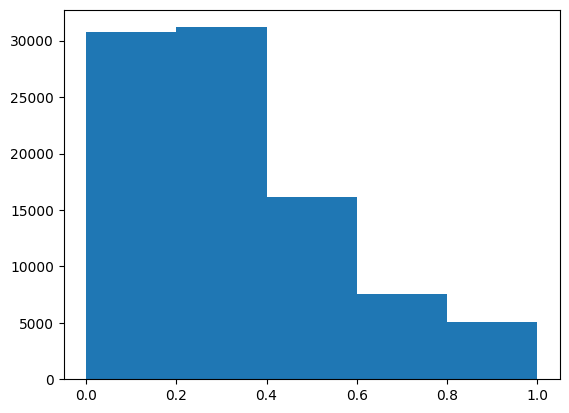

In [ ]:
plt.hist(sim_agreed, bins =[0,0.2,0.4,0.6,0.8,1.0] )
plt.show()

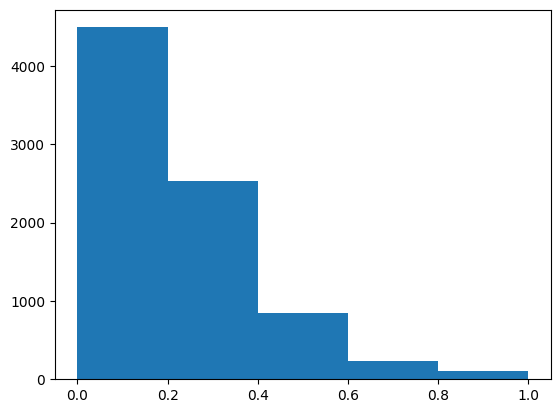

In [ ]:
plt.hist(sim_disagreed, bins =[0,0.2,0.4,0.6,0.8,1.0] )
plt.show()

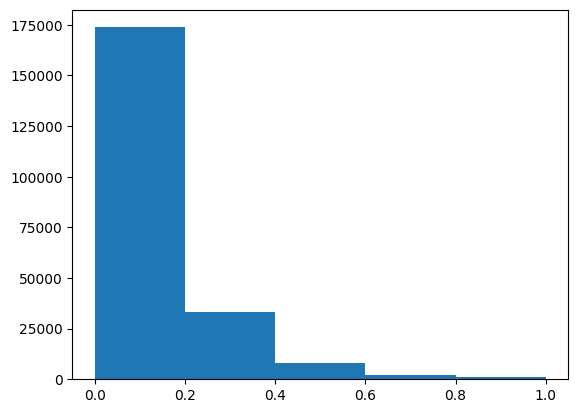

In [ ]:
plt.hist(sim_unrelated, bins =[0,0.2,0.4,0.6,0.8,1.0] )
plt.show()

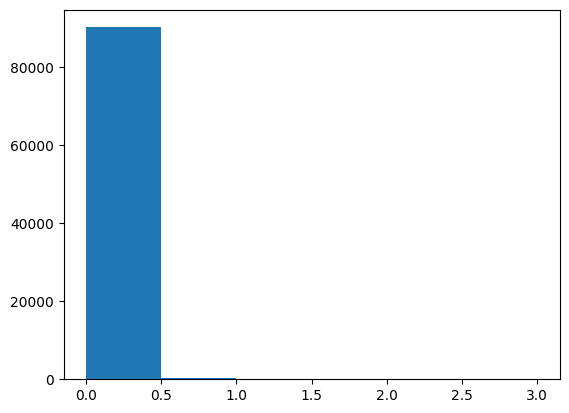

In [ ]:
plt.hist(sim_agreed_m1, bins = [0,0.5,1.0,1.5,2.0,2.5,3])
plt.show()

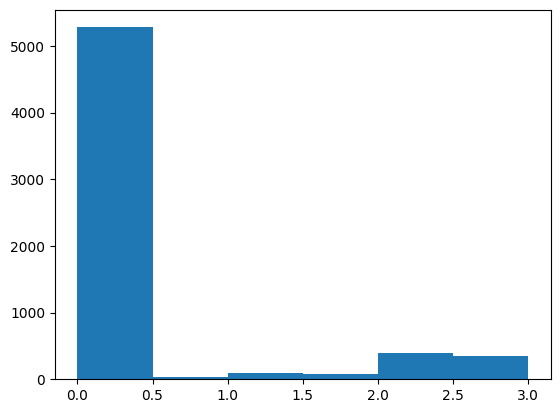

In [ ]:
plt.hist(sim_disagreed_m1, bins = [0,0.5,1.0,1.5,2.0,2.5,3])
plt.show()

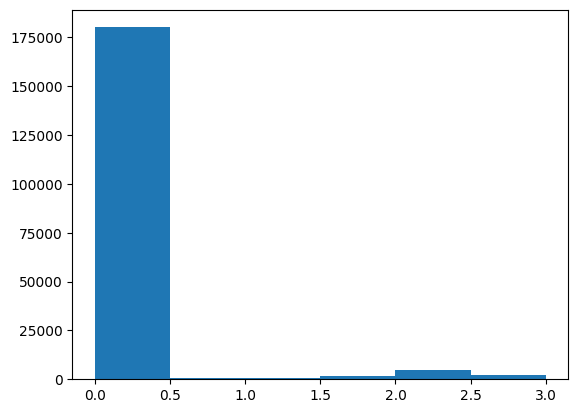

In [ ]:
plt.hist(sim_unrelated_m1, bins = [0,0.5,1.0,1.5,2.0,2.5,3])
plt.show()

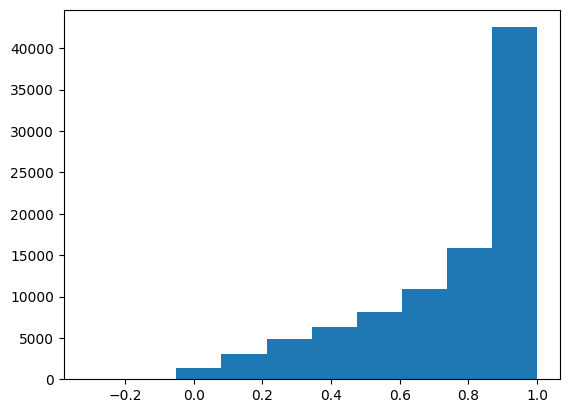

In [ ]:
plt.hist(sim_agreed_svd_cs)
plt.show()

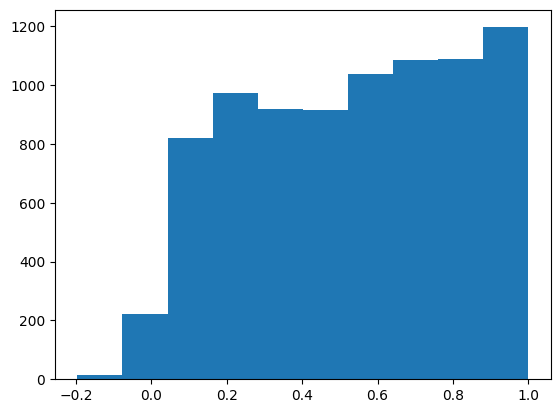

In [ ]:
plt.hist(sim_disagreed_svd_cs)
plt.show()

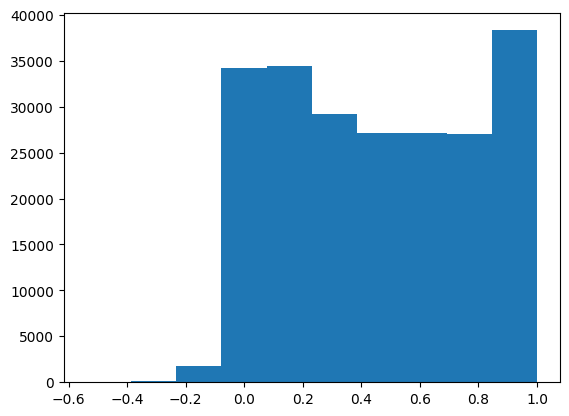

In [ ]:
plt.hist(sim_unrelated_svd_cs)
plt.show()

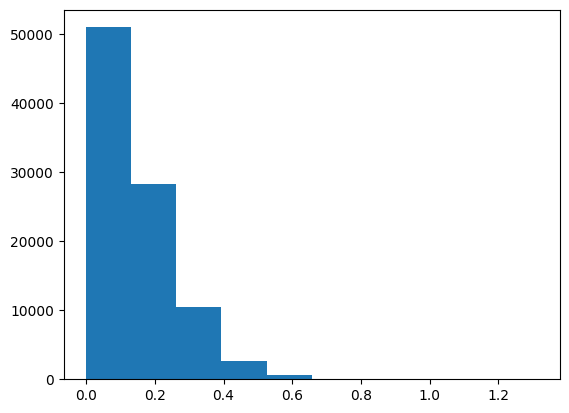

In [ ]:
plt.hist(sim_agreed_svd_ed)
plt.show()

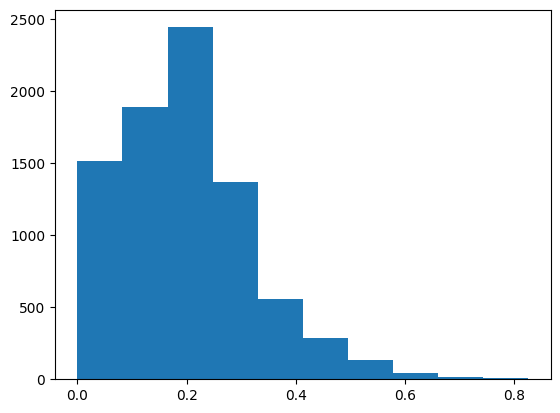

In [ ]:
plt.hist(sim_disagreed_svd_ed)
plt.show()

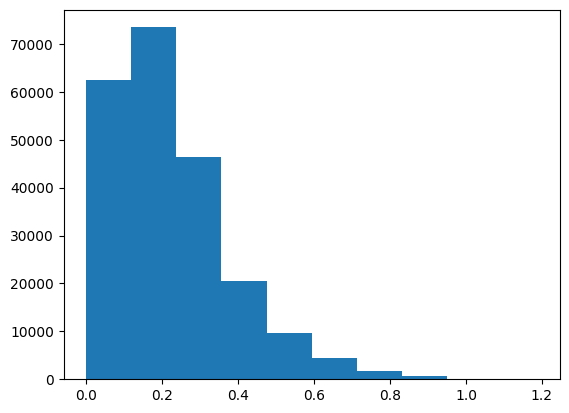

In [ ]:
plt.hist(sim_unrelated_svd_ed)
plt.show()

In [ ]:
bert_sim_cs_agreed = bert_sim_cs_agreed[:count1]
bert_sim_cs_disagreed = bert_sim_cs_disagreed[:count2]
bert_sim_cs_unrelated = bert_sim_cs_unrelated[:count3]

In [ ]:
bert_sim_cs_unrelated

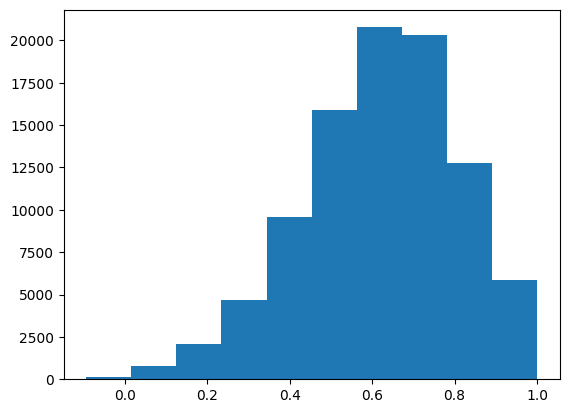

In [ ]:
plt.hist(bert_sim_cs_agreed)
plt.show()

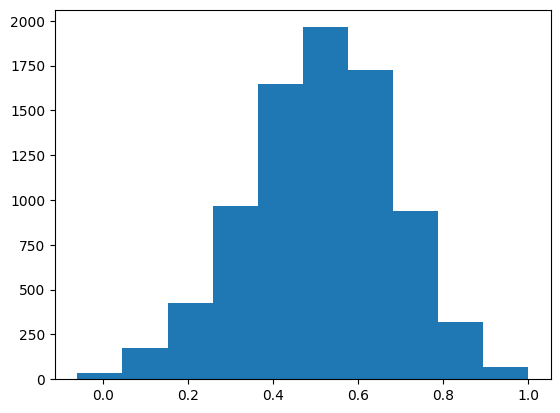

In [ ]:
plt.hist(bert_sim_cs_disagreed)
plt.show()

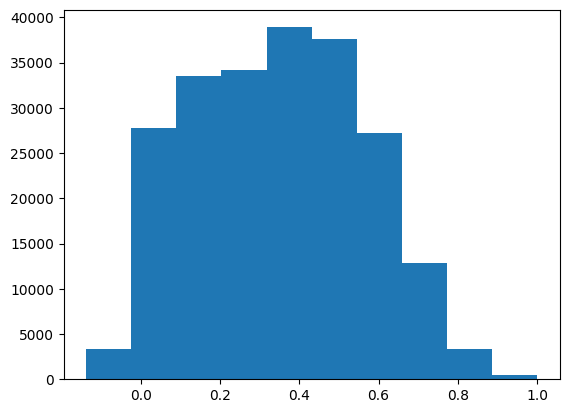

In [ ]:
plt.hist(bert_sim_cs_unrelated)
plt.show()

## Histogram of topic features - topic_agreed_cs, topic_disagreed_cs, topic_unrelated_cs, topic_agreed_ed, topic_disagreed_ed, topic_unrelated_ed

In [ ]:
topic_agreed_cs[0]

array([[0.79900448]])

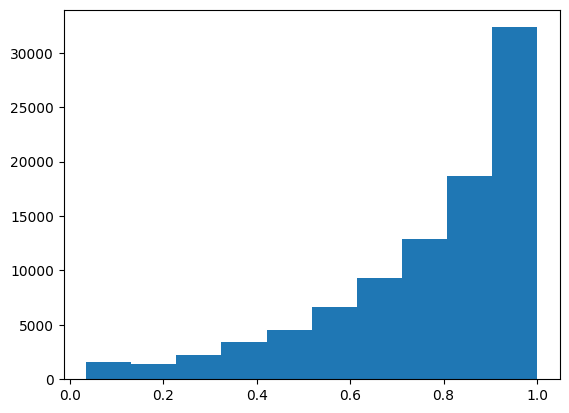

In [ ]:
plt.hist(topic_agreed_cs)
plt.show()

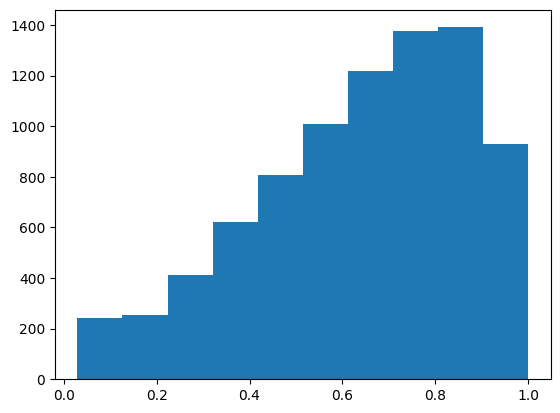

In [ ]:
plt.hist(topic_disagreed_cs)
plt.show()

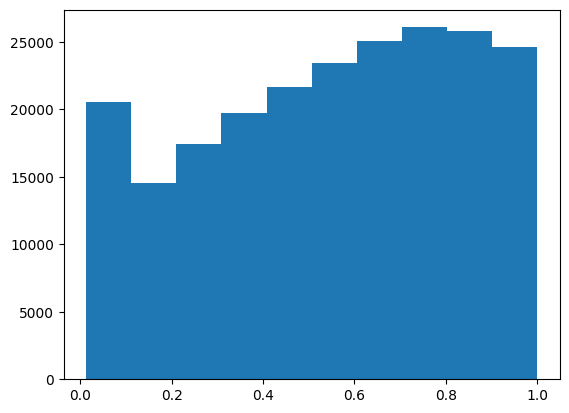

In [ ]:
plt.hist(topic_unrelated_cs)
plt.show()

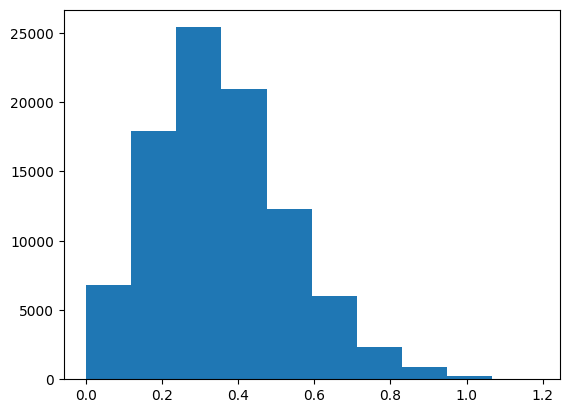

In [ ]:
plt.hist(topic_agreed_ed)
plt.show()

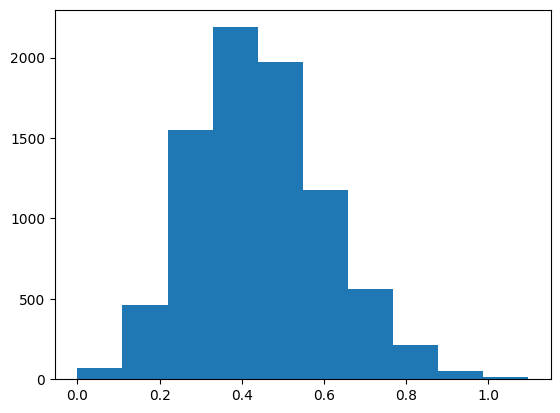

In [ ]:
plt.hist(topic_disagreed_ed)
plt.show()

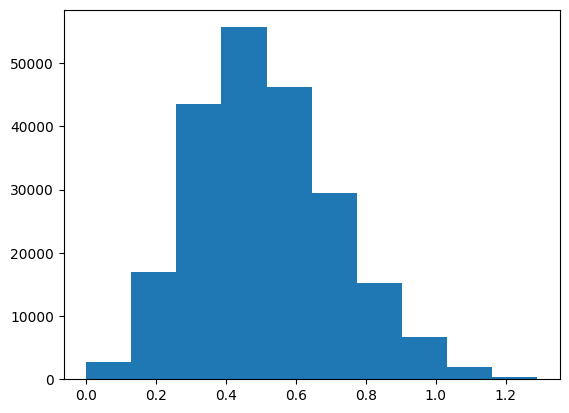

In [ ]:
plt.hist(topic_unrelated_ed)
plt.show()

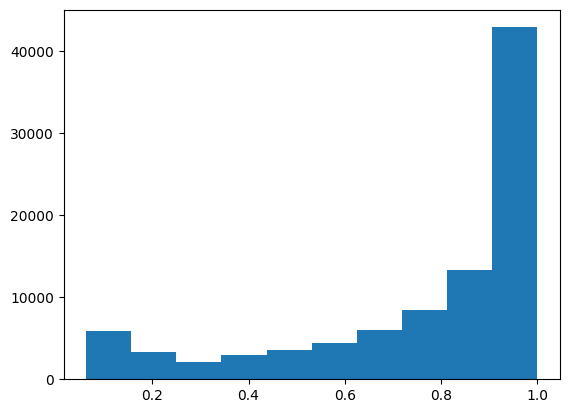

In [ ]:
plt.hist(topic_agreed_cs_idf)
plt.show()

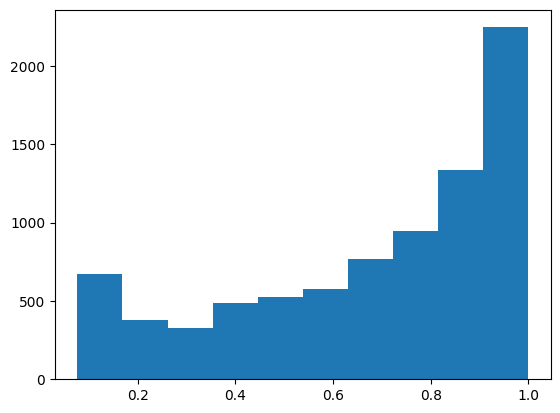

In [ ]:
plt.hist(topic_disagreed_cs_idf)
plt.show()

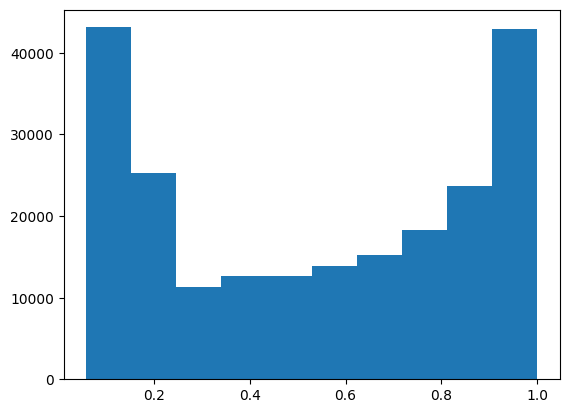

In [ ]:
plt.hist(topic_unrelated_cs_idf)
plt.show()

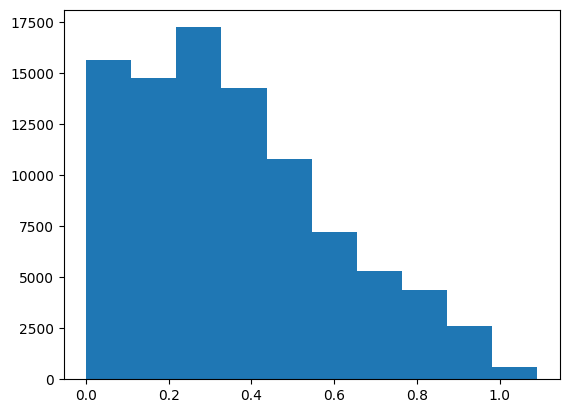

In [ ]:
plt.hist(topic_agreed_ed_idf)
plt.show()

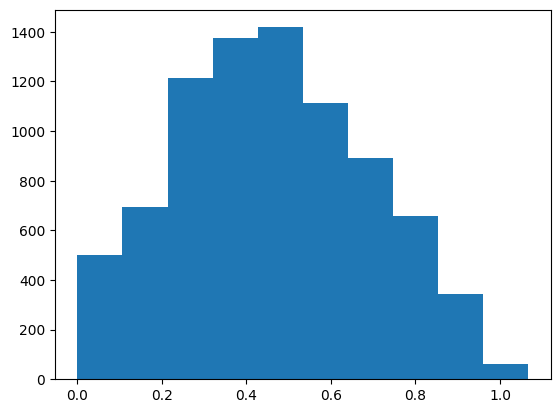

In [ ]:
plt.hist(topic_disagreed_ed_idf)
plt.show()

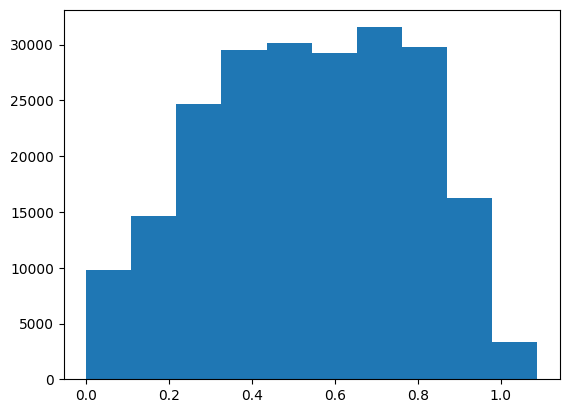

In [ ]:
plt.hist(topic_unrelated_ed_idf)
plt.show()

## Sentiment features histogram

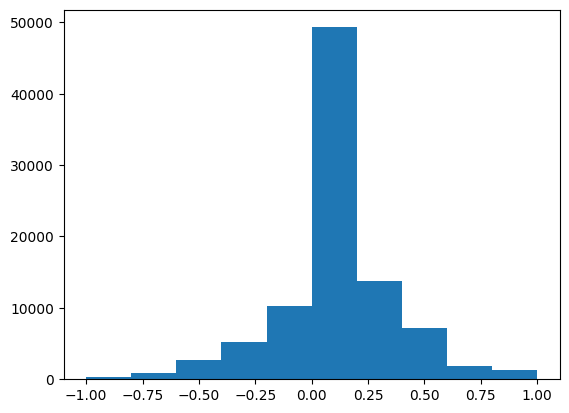

In [ ]:
plt.hist(sentiment_agreed_t1_polarity)
plt.show()

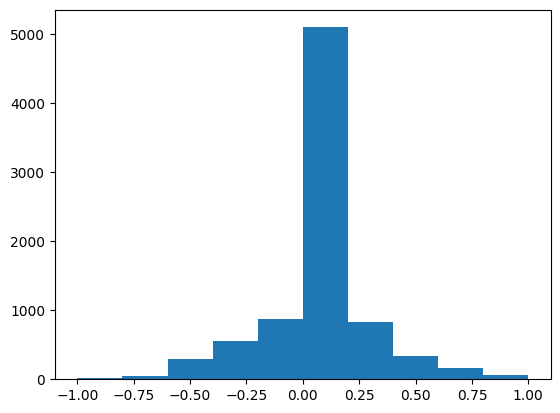

In [ ]:
plt.hist(sentiment_disagreed_t1_polarity)
plt.show()

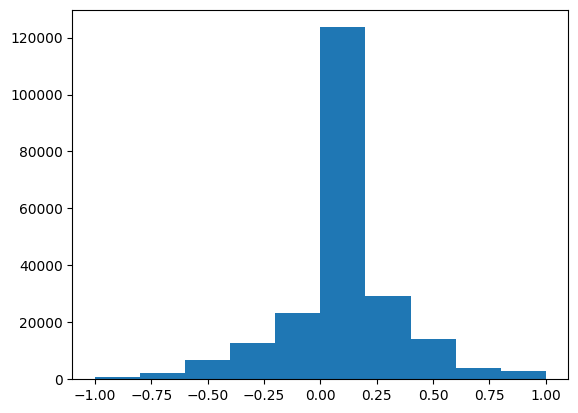

In [ ]:
plt.hist(sentiment_unrelated_t1_polarity)
plt.show()

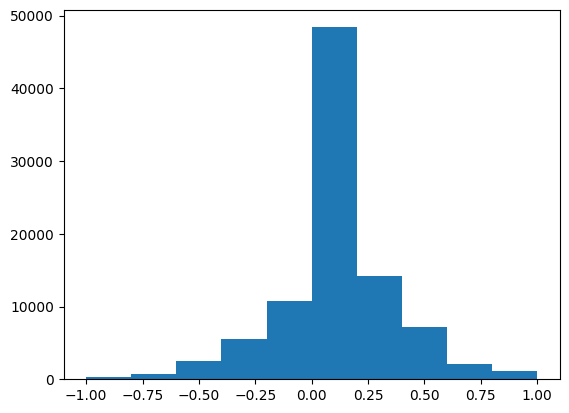

In [ ]:
plt.hist(sentiment_agreed_t2_polarity)
plt.show()

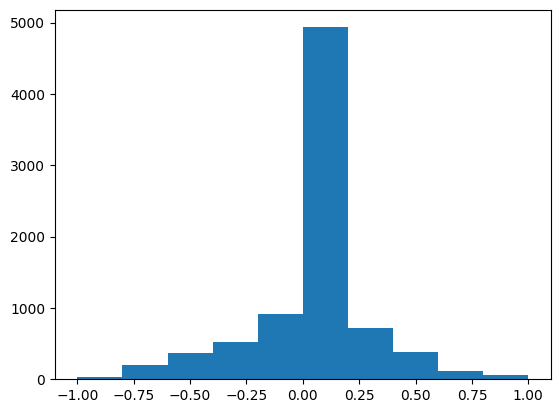

In [ ]:
plt.hist(sentiment_disagreed_t2_polarity)
plt.show()

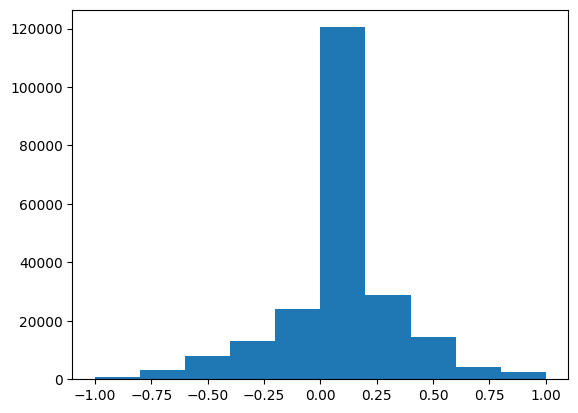

In [ ]:
plt.hist(sentiment_unrelated_t2_polarity)
plt.show()

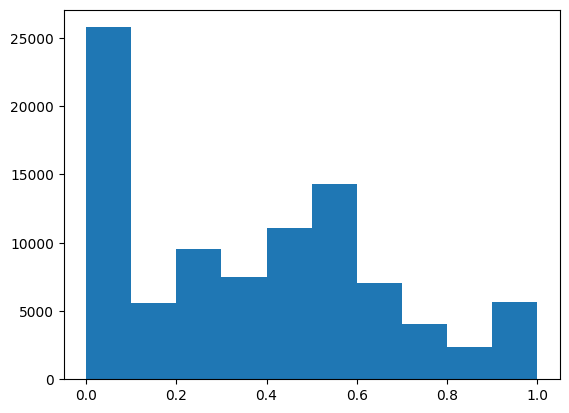

In [ ]:
plt.hist(sentiment_agreed_t1_subjectivity)
plt.show()

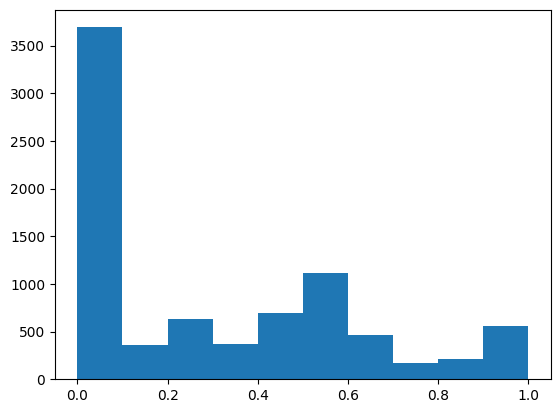

In [ ]:
plt.hist(sentiment_disagreed_t1_subjectivity)
plt.show()

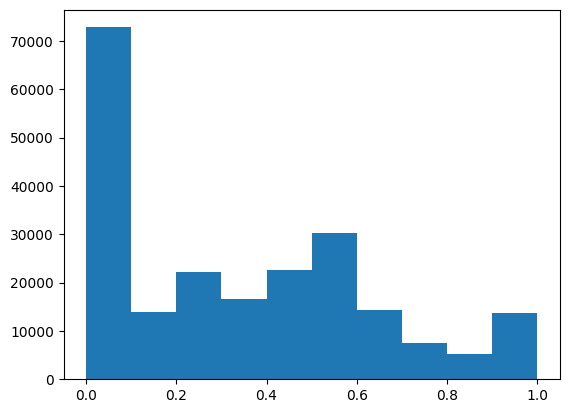

In [ ]:
plt.hist(sentiment_unrelated_t1_subjectivity)
plt.show()

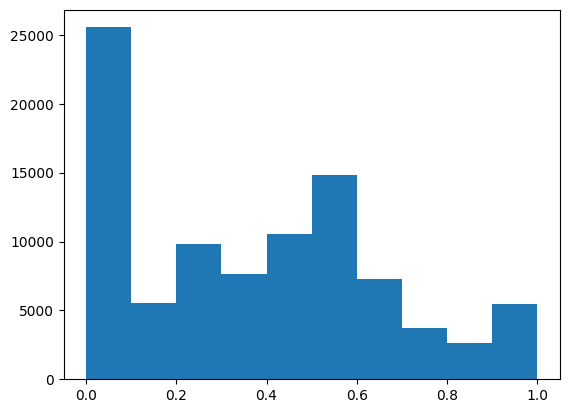

In [ ]:
plt.hist(sentiment_agreed_t2_subjectivity)
plt.show()

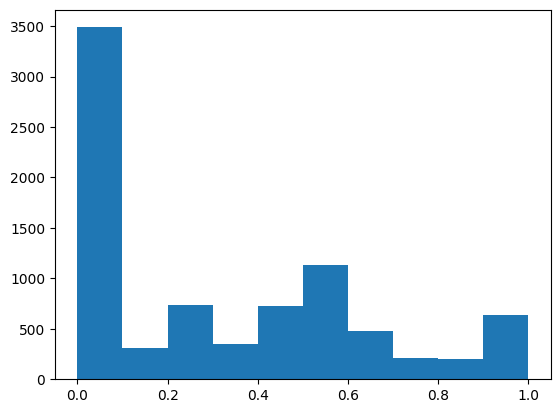

In [ ]:
plt.hist(sentiment_disagreed_t2_subjectivity)
plt.show()

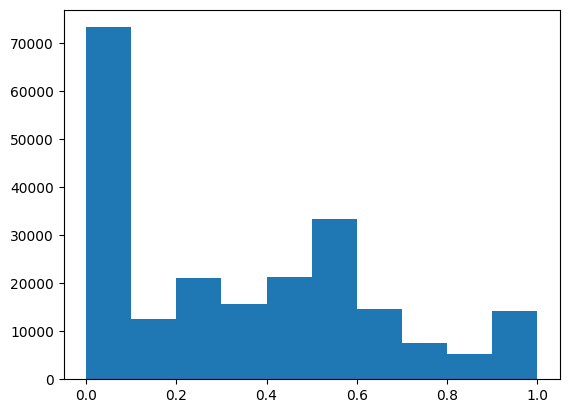

In [ ]:
plt.hist(sentiment_unrelated_t2_subjectivity)
plt.show()

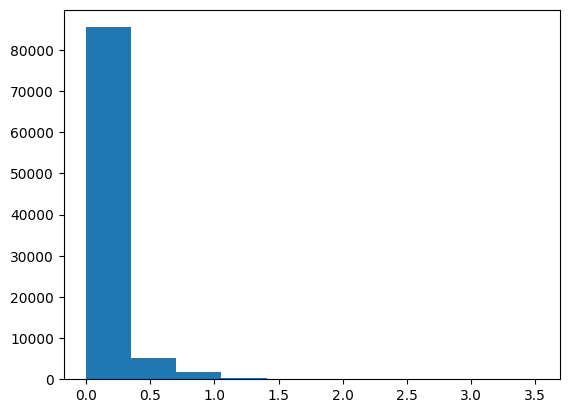

In [ ]:
plt.hist(sentiment_agreed_polarity_diff)
plt.show()


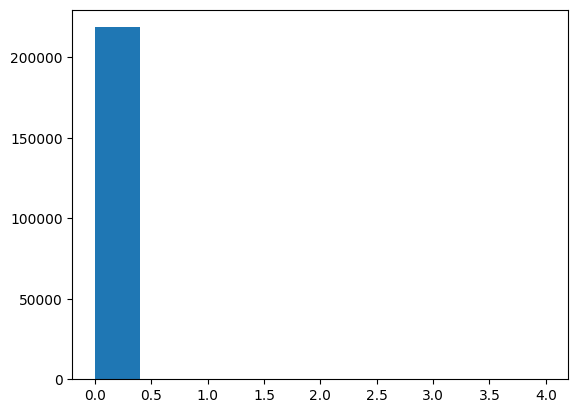

In [ ]:
plt.hist(sentiment_disagreed_polarity_diff)
plt.show()

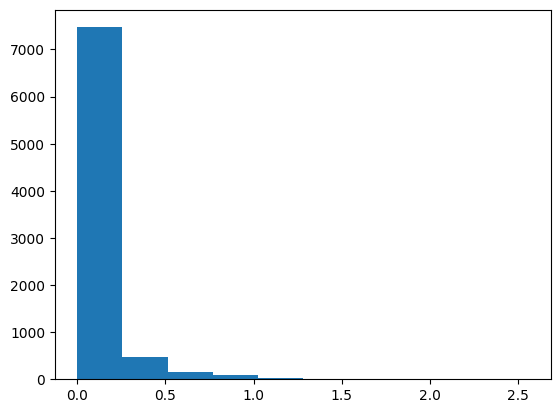

In [ ]:
plt.hist(sentiment_unrelated_polarity_diff)
plt.show()

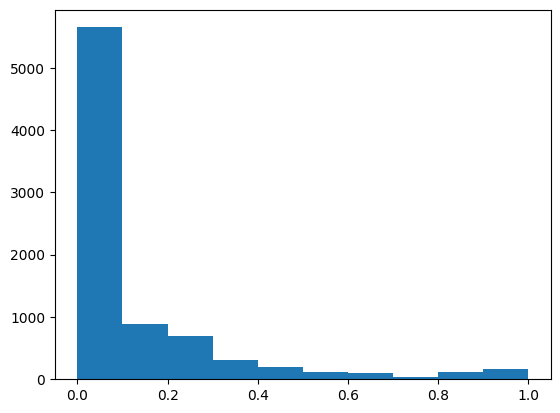

In [ ]:
plt.hist(sentiment_agreed_subjectivity_diff)
plt.show()

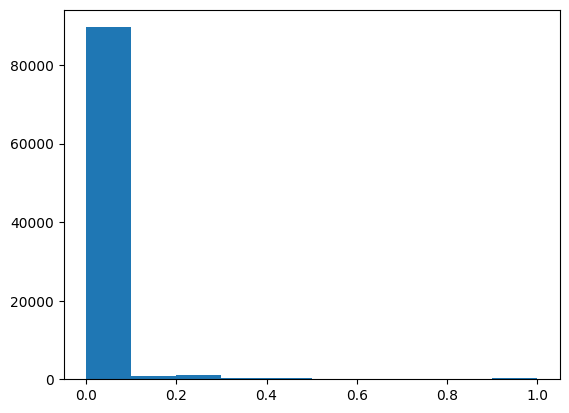

In [ ]:
plt.hist(sentiment_disagreed_subjectivity_diff)
plt.show()

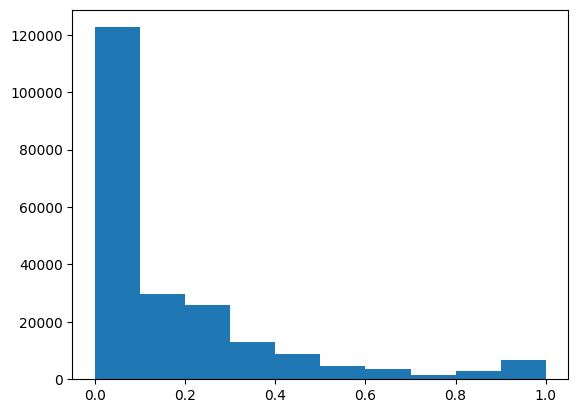

In [ ]:
plt.hist(sentiment_unrelated_subjectivity_diff)
plt.show()

## WMD features histogram

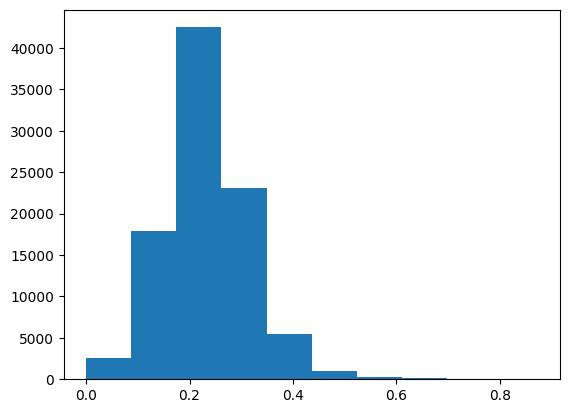

In [ ]:
plt.hist(wmd_agreed)
plt.show()

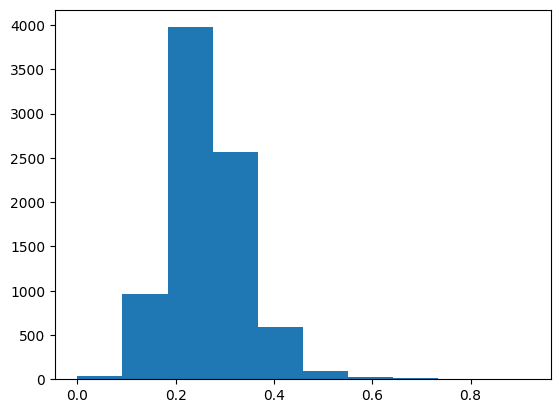

In [ ]:
plt.hist(wmd_disagreed)
plt.show()

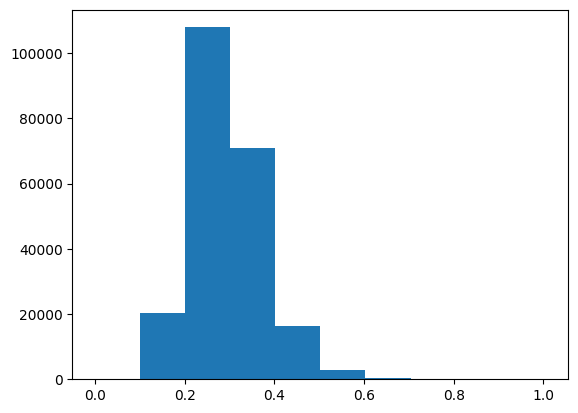

In [ ]:
plt.hist(wmd_unrelated)
plt.show()

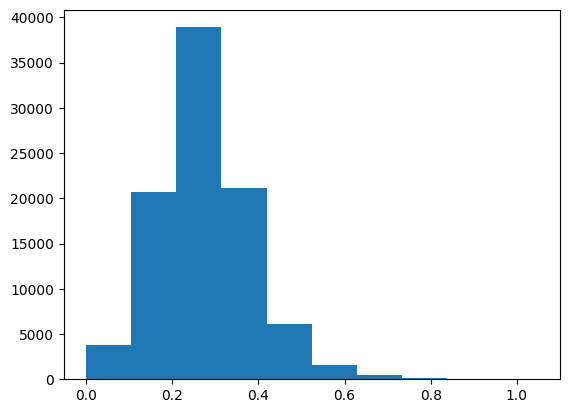

In [ ]:
plt.hist(wmd_agreed_lem)
plt.show()

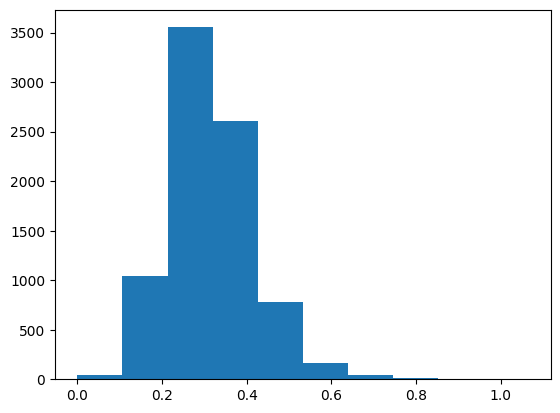

In [ ]:
plt.hist(wmd_disagreed_lem)
plt.show()

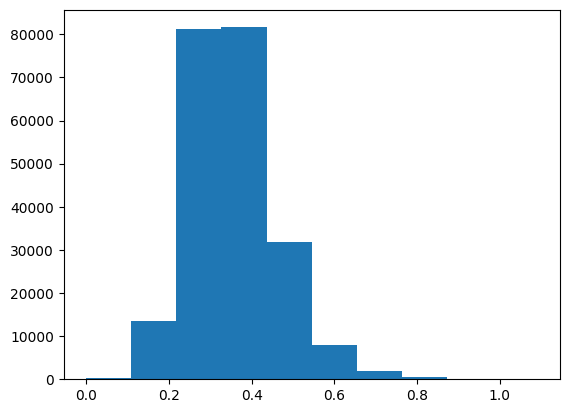

In [ ]:
plt.hist(wmd_unrelated_lem)
plt.show()

## SVD Similarity cosine and ED histogram plot!



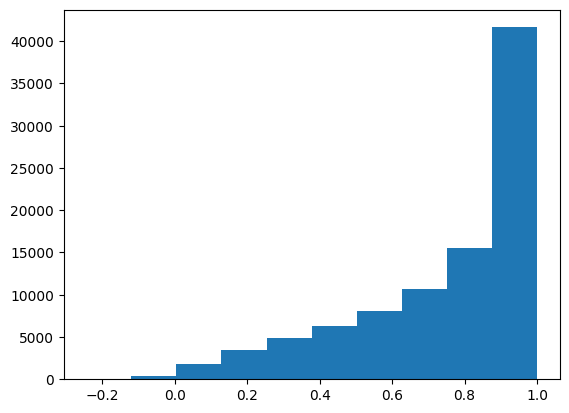

In [ ]:
plt.hist(sim_agreed_svd_cs)
plt.show()

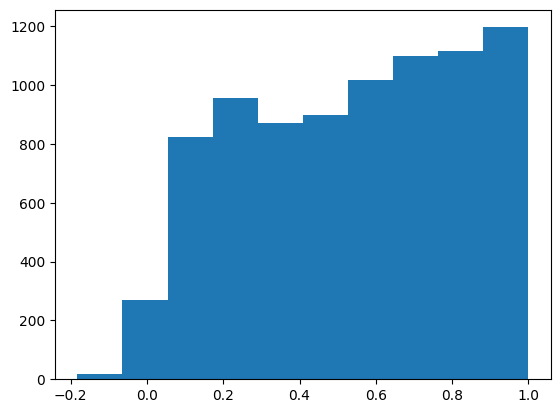

In [ ]:
plt.hist(sim_disagreed_svd_cs)
plt.show()

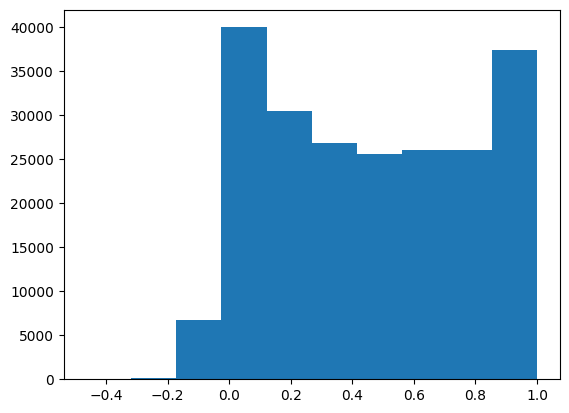

In [ ]:
plt.hist(sim_unrelated_svd_cs)
plt.show()

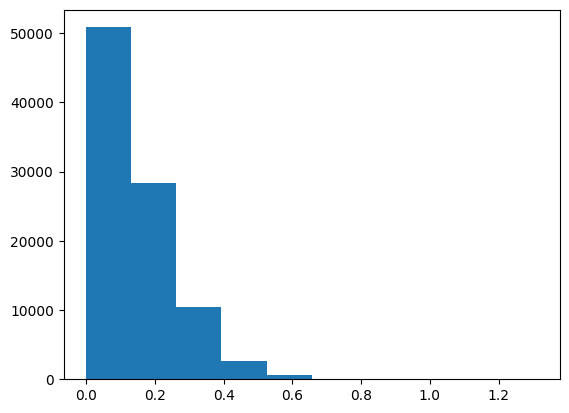

In [ ]:
plt.hist(sim_agreed_svd_ed)
plt.show()

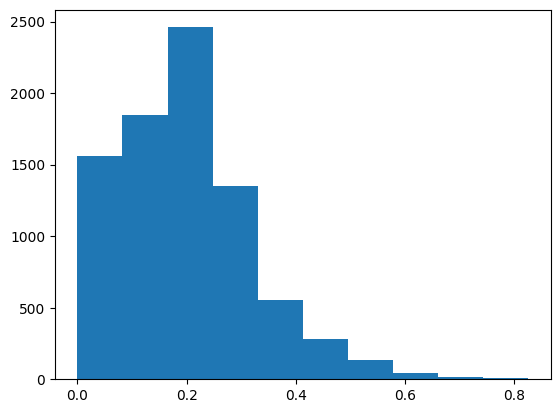

In [ ]:
plt.hist(sim_disagreed_svd_ed)
plt.show()

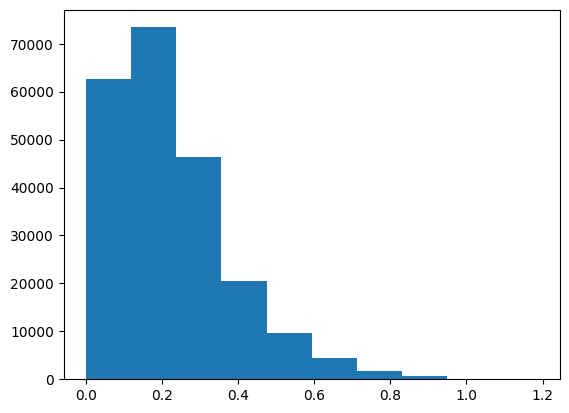

In [ ]:
plt.hist(sim_unrelated_svd_ed)
plt.show()